<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/11_cnn_pytorch/10_multitask_applied_mtdssd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# マルチタスク学習応用（検出＋セグメンテーション）
---

# 目的

これまでに学習したSSD・SegNet・マルチタスク学習を応用し，物体検出タスクとセマンティックセグメンテーションタスクを同時に解くネットワークを実際に作成する．

## 概要
物体検出とセマンティックセグメンテーションを行うモデルとして，Multi-task Deconvolutional Single Shot Detector（MT-DSSD） [1] があります．MT-DSSDは，SSD [2] にDeconvolution層を追加したDeconvolutional Single Shot Detector（DSSD） [3] にセグメンテーションを行うブランチを追加したものです．各ブランチで物体識別，物体候補領域の検出，セマンティックセグメンテーションを行うことで，単一のモデルで物体検出とセマンティックセグメンテーションタスクを同時に解くことができます．


# 準備
## Google Colaboratoryの設定確認・変更
本チュートリアルではPyTorchを利用してニューラルネットワークの実装を確認，学習および評価を行います． GPUを用いて処理を行うために，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．

# データセットの用意
今回もSSDおよびSegNetと同様に，物体検出タスクの性能評価に用いられるARC2017 RGB-Dデータセットを使用します．ARC2017 RGB-Dデータセットは2017年にAmazon Robotics Challengeにて使用された全40クラスの物体を収録する物体検出のデータセットです．
ARC2017 RGB-Dデータセットの詳細については以下サイトを参照してください．
http://mprg.jp/research/arc_dataset_2017_j

In [1]:
# データのダウンロード
!wget http://www.mprg.cs.chubu.ac.jp/MPRG_Seminar2020/ARCdataset_png_for_MTDSSD.zip
!unzip -q ARCdataset_png_for_MTDSSD.zip 

--2021-03-02 02:02:46--  http://www.mprg.cs.chubu.ac.jp/MPRG_Seminar2020/ARCdataset_png_for_MTDSSD.zip
Resolving www.mprg.cs.chubu.ac.jp (www.mprg.cs.chubu.ac.jp)... 157.110.42.95
Connecting to www.mprg.cs.chubu.ac.jp (www.mprg.cs.chubu.ac.jp)|157.110.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 356763467 (340M) [application/zip]
Saving to: ‘ARCdataset_png_for_MTDSSD.zip’

ARCdataset_png_for_ 100%[===================>] 340.24M  6.46MB/s    in 55s     

2021-03-02 02:03:42 (6.20 MB/s) - ‘ARCdataset_png_for_MTDSSD.zip’ saved [356763467/356763467]



データセットの中身はSSD・SegNetと同様なので，詳しくは省略します．

ダウンロードしたデータの中身を確認します．
フォルダARCdataset_pngには以下のフォルダ・ファイルが内包されています． \\
- train ← 学習用データ
- test ← 評価用データ
- SSD_pretrained.pth ← 学習済みモデル \\

作業ディレクトリを先程ダウンロードしたフォルダに移動します．



In [2]:
# 作業ディレクトリの移動
%cd ARCdataset_png_for_MTDSSD
!ls

/content/ARCdataset_png_for_MTDSSD
MTDSSD_pretrained.pth  train  val


## モジュールのインポート
SSDと同様に，プログラムを実行するために必要なモジュールをインポートします．

In [3]:
import datetime
from glob import glob
import os
import sys
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from pylab import *

import math # 数学ライブラリ
import random # 乱数生成
import cv2 as cv    # 画像処理
import numpy as np  # 計算
import torch        # 機械学習ライブラリ
import torchsummary # ネットワーク情報表示
import torch.nn as nn
import torch.optim as optim
from torch.nn import init
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

実験はGPUを使用するので，colaboratory上で使用可能な状態か確認します．
`device:cuda`と表示されない場合は，上記の「Google Colaboratoryの設定確認・変更」を確認してください．

In [4]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print('device:{}'.format(device))

device:cuda


In [5]:
!nvidia-smi

Tue Mar  2 02:03:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

最初に，評価する画像が入ったフォルダやネットワークのハイパーパラメータを定義します．後に作成するネットワーク定義やテストプログラムからも，値を参照できるようにしておきます．

ほとんどSSDと同じですが，セグメンテーション用の教師ラベルリストのパスを指定する`self.augmented_seglabel_list`が追加されています．

In [6]:
class common:
  def __init__(self):
    # 学習画像のディレクトリ
    self.images_dir = "."

    # Data Augmentationにより作成されたデータのリストパス（入力画像）
    self.augmented_img_list = "./train/augimg_name_list.txt"

    # Data Augmentationにより作成されたデータのリストパス（セグメンテーション）
    self.augmented_seglabel_list = "./train/seglabel_name_list.txt"

    # SSDの入力画像サイズ
    self.insize = 300

    # 識別のクラス数 (背景込み)
    self.num_of_classes = 41

    # Bounding boxのオフセットベクトルの次元数
    self.num_of_offset_dims = 4

    # Bounding boxのオフセットとクラスを推定する畳み込み層
    self.mbox_source_layers = ['conv4_3', 'conv7', 'conv8_2', 'conv9_2', 'conv10_2', 'conv11_2']

    # Default boxの最小・最大比率 (in percent %)
    self.min_ratio = 20
    self.max_ratio = 90

    # 各階層における特徴マップの入力画像上のステップ幅
    self.steps = [8, 16, 32, 64, 100, 300]

    # 各階層のdefault boxの数
    self.num_boxes = [4, 6, 6, 6, 4, 4]

    # 各階層の特徴マップのDefault boxのアスペクト比
    self.aspect_ratios = [[2], [2, 3], [2, 3], [2, 3], [2], [2]]

    # 各階層の特徴マップの解像度
    self.map_sizes = [38, 19, 10, 5, 3, 1]

    self.loc_var = 0.01

    # Data Augmentationで増加させる倍数
    self.augmentation_factor = 2

    # Data Augmentationのパラメータ
    self.jitter = 0.3      # Default : 0.2
    self.saturation = 1.5  # Default : 1.5
    self.exposure = 1.5    # Default : 1.5
    self.hue = 0.03        # Default : 0.03

    # choose border type
    # BORDER_REPLICATE, BORDER_REFLECT, BORDER_REFLECT_101, BORDER_WRAP, BORDER_CONSTANT
    self.border_type = cv.BORDER_CONSTANT

    self.border_val = (127, 127, 127)

    # ARCクラスラベル (クラス名にはスペース(空白)は禁止)
    self.arc_labels = [
          "Background",             #0
          "Binder",                 #1
          "Balloons",               #2
          "Baby_Wipes",             #3
          "Toilet_Brush",           #4
          "Toothbrushes",           #5
          "Crayons",                #6
          "Salts",                  #7
          "DVD",                    #8
          "Glue_Sticks",            #9
          "Eraser",                 #10
          "Scissors",               #11
          "Green_Book",             #12
          "Socks",                  #13
          "Irish_Spring",           #14
          "Paper_Tape",             #15
          "Touch_Tissues",          #16
          "Knit_Gloves",            #17
          "Laugh_Out_Loud_Jokes",   #18
          "Pencil_Cup",             #19
          "Mini_Marbles",           #20
          "Neoprene_Weight",        #21
          "Wine_Glasses",           #22
          "Water_Bottle",           #23
          "Reynolds_Pie",           #24
          "Reynolds_Wrap",          #25
          "Robots_Everywhere",      #26
          "Duct_Tape",              #27
          "Sponges",                #28
          "Speed_Stick",            #29
          "Index_Cards",            #30
          "Ice_Cube_Tray",          #31
          "Table_Cover",            #32
          "Measuring_Spoons",       #33
          "Bath_Sponge",            #34
          "Pencils",                #35
          "Mousetraps",             #36
          "Face_Cloth",             #37
          "Tennis_Balls",           #38
          "Spray_Bottle",           #39
          "Flashlights"]            #40

    # アイテムIDリスト
    self.itemIDList = [
                  "0 BG",
                  "1",
                  "2",
                  "3",
                  "4",
                  "5",
                  "6",
                  "7",
                  "8",
                  "9",
                  "10",
                  "11",
                  "12",
                  "13",
                  "14",
                  "15",
                  "16",
                  "17",
                  "18",
                  "19",
                  "20",
                  "21",
                  "22",
                  "23",
                  "24",
                  "25",
                  "26",
                  "27",
                  "28",
                  "29",
                  "30",
                  "31",
                  "32",
                  "33",
                  "34",
                  "35",
                  "36",
                  "37",
                  "38",
                  "39",
                  "40",
                  "41"]

    # クラスの色
    self.arc_class_color = np.array([
               [  0,   0,   0],
               [ 85,   0,   0],
               [170,   0,   0],
               [255,   0,   0],
               [  0,  85,   0],
               [ 85,  85,   0],
               [170,  85,   0],
               [255,  85,   0],
               [  0, 170,   0],
               [ 85, 170,   0],
               [170, 170,   0],
               [255, 170,   0],
               [  0, 255,   0],
               [ 85, 255,   0],
               [170, 255,   0],
               [255, 255,   0],
               [  0,   0,  85],
               [ 85,   0,  85],
               [170,   0,  85],
               [255,   0,  85],
               [  0,  85,  85],
               [ 85,  85,  85],
               [170,  85,  85],
               [255,  85,  85],
               [  0, 170,  85],
               [ 85, 170,  85],
               [170, 170,  85],
               [255, 170,  85],
               [  0, 255,  85],
               [ 85, 255,  85],
               [170, 255,  85],
               [255, 255,  85],
               [  0,   0, 170],
               [ 85,   0, 170],
               [170,   0, 170],
               [255,   0, 170],
               [  0,  85, 170],
               [ 85,  85, 170],
               [170,  85, 170],
               [255,  85, 170],
               [  0, 170, 170]])

common_params = common()

## データ拡張
Data Augmentationの処理を記述します．trainフォルダ内にデータ拡張済みのBoundingBoxファイルが用意されており，データ拡張済みのファイルが読み込まれた際に画像に対してData Augmentation処理が実行されます．\
読み込まれたRGB画像は一度HSV形式に変換され，歪みを加えたRGB画像を新たに生成します．

この部分も基本的にはSSDと同じですが，セグメンテーションの教師ラベルを取り扱う処理が追加されています．セグメンテーションの教師ラベルはdata augmentation時に色を変化させてはいけないため，crop処理のみ追加します．


In [7]:
# BGR -> HSV
def BGR_2_HSV_(img):

    h = np.zeros((img.shape[0], img.shape[1]), np.float32)
    s = np.zeros((img.shape[0], img.shape[1]), np.float32)
    v = np.zeros((img.shape[0], img.shape[1]), np.float32)

    img_r = img.copy()
    b = img[:, :, 0]
    g = img[:, :, 1]
    r = img[:, :, 2]
    max_v = cv.max(cv.max(b, g), r)
    min_v = cv.min(cv.min(b, g), r)
    delta = max_v - min_v
    v = max_v
    zero_m = (max_v == 0.)
    zero_m = zero_m.astype(np.float32)
    nonzeor_m = (max_v != 0.)
    nonzeor_m = nonzeor_m.astype(np.float32)

    exp_m = zero_m * 10e-8

    s = delta / (max_v + exp_m)
    s = s * nonzeor_m

    rmax = (r == max_v)
    rmax = rmax.astype(np.float32)

    gmax = (g == max_v)
    gr = (g != r)
    gmax = gmax.astype(np.float32)
    gr = gr.astype(np.float32)
    gmax = gmax * gr

    bmax = (b == max_v)
    br = (b != r)
    bg = (b != g)
    bmax = bmax.astype(np.float32)
    br = br.astype(np.float32)
    bg = bg.astype(np.float32)
    bmax = bmax * br * bg

    h += ((g - b) / (delta + 10e-8)) * rmax
    h += (((b - r) / (delta + 10e-8)) + 2.) * gmax
    h += (((r - g) / (delta + 10e-8)) + 4.) * bmax

    h = h * (np.pi / 3.)

    neg_m = (h < 0.0)
    neg_m = neg_m.astype(np.float32)
    h += neg_m * (2. * np.pi)

    h = h / (2. * np.pi)

    img_r[:, :, 0] = h
    img_r[:, :, 1] = s
    img_r[:, :, 2] = v

    return img_r

# HSV -> BGR
def HSV_2_BGR_(img):

    r = np.zeros((img.shape[0], img.shape[1]), np.float32)
    g = np.zeros((img.shape[0], img.shape[1]), np.float32)
    b = np.zeros((img.shape[0], img.shape[1]), np.float32)

    img_r = img.copy()
    h = img[:, :, 0]
    s = img[:, :, 1]
    v = img[:, :, 2]

    h = h * (2. * np.pi)

    zero_m = (s == 0.)
    zero_m = zero_m.astype(np.float32)
    nonzeor_m = (s != 0.)
    nonzeor_m = nonzeor_m.astype(np.float32)

    idx = np.floor(h)
    idx = idx.astype(np.int16)

    f = h - idx
    p = v * (1. - s)
    q = v * (1. - s * ((3. / np.pi) * f))
    t = v * (1. - s * (1. - ((3. / np.pi) * f)))

    idx0 = (idx == 0)
    idx0 = idx0.astype(np.float32)

    idx1 = (idx == 1)
    idx1 = idx1.astype(np.float32)

    idx2 = (idx == 2)
    idx2 = idx2.astype(np.float32)

    idx3 = (idx == 3)
    idx3 = idx3.astype(np.float32)

    idx4 = (idx == 4)
    idx4 = idx4.astype(np.float32)

    idxE = idx0 + idx1 + idx2 + idx3 + idx4
    idxE = (idxE == 0)
    idxE = idxE.astype(np.float32)

    r += v * idx0
    g += t * idx0
    b += p * idx0

    r += q * idx1
    g += v * idx1
    b += p * idx1

    r += p * idx2
    g += v * idx2
    b += t * idx2

    r += p * idx3
    g += q * idx3
    b += v * idx3

    r += t * idx4
    g += p * idx4
    b += v * idx4

    r += v * idxE
    g += p * idxE
    b += q * idxE

    r = r * nonzeor_m
    g = g * nonzeor_m
    b = b * nonzeor_m

    r += v * zero_m
    g += v * zero_m
    b += v * zero_m

    img_r[:, :, 0] = b
    img_r[:, :, 1] = g
    img_r[:, :, 2] = r

    return img_r

# 歪みをくわえた画像を生成
def distortImage(img, dhue, dsat, dexp):

    img = BGR_2_HSV_(img)

    n = img.shape[0] * img.shape[1]

    img[:, :, 0] = img[:, :, 0] + dhue
    img[:, :, 1] = img[:, :, 1] * dsat
    img[:, :, 2] = img[:, :, 2] * dexp

    m = img[:, :, 0] > 1.
    m = m.astype(np.float32)
    p = img[:, :, 0] < 0.
    p = p.astype(np.float32)

    img[:, :, 0] = img[:, :, 0] - m
    img[:, :, 0] = img[:, :, 0] + p

    img = HSV_2_BGR_(img)

    img = np.minimum(np.maximum(img, 0.), 1.)

    return img


# augmentation処理
def trainAugmentation(img, border_pixels, crop_param, hsv_param, flip_type, segimg):
    hsv_srand = 0

    if hsv_srand == 1:
        dhue = hsv_param[0]
        dsat = hsv_param[1]
        dexp = hsv_param[2]
    else:
        dhue = random.uniform(-1. * common_params.hue, common_params.hue)
        dsat = random.uniform(1., common_params.saturation)
        dexp = random.uniform(1., common_params.exposure)
        if random.randint(0, 1) == 0:
            dsat = 1. / dsat
        if random.randint(0, 1) == 0:
            dexp = 1. / dexp

    if random.randint(0, 4) >= 1:
        img = img.astype(np.float32)
        img /= 255.
        img = distortImage(img, dhue, dsat, dexp)
        img *= 255.
        img = img.astype(np.uint8)


    if common_params.border_type == cv.BORDER_CONSTANT:
        cropped_img = cv.copyMakeBorder(img, border_pixels[1], border_pixels[3], border_pixels[0], border_pixels[2], common_params.border_type, value = common_params.border_val)
        cropped_segimg = cv.copyMakeBorder(segimg, border_pixels[1], border_pixels[3], border_pixels[0], border_pixels[2], cv.BORDER_REPLICATE)
    else:
        cropped_img = cv.copyMakeBorder(img, border_pixels[1], border_pixels[3], border_pixels[0], border_pixels[2], common_params.border_type)
        cropped_segimg = cv.copyMakeBorder(segimg, border_pixels[1], border_pixels[3], border_pixels[0], border_pixels[2], cv.BORDER_REPLICATE)

    cropped_img = cv.getRectSubPix(cropped_img, (int(crop_param[2]), int(crop_param[3])), (crop_param[0], crop_param[1]))
    cropped_img = cv.resize(cropped_img, (common_params.insize, common_params.insize), interpolation = cv.INTER_CUBIC)


    w = crop_param[2]
    h = crop_param[3]
    cx = crop_param[0]
    cy = crop_param[1]
    cropped_segimg = cropped_segimg[int(cy-h/2):int(cy+h/2), int(cx-w/2):int(cx+w/2)]

    cropped_segimg = cv.resize(cropped_segimg, (common_params.insize, common_params.insize), interpolation = cv.INTER_NEAREST)


    if flip_type >= 0:
        cropped_img = cv.flip(cropped_img, flip_type)
        cropped_segimg = cv.flip(cropped_segimg, flip_type)

    return (cropped_img, cropped_segimg)

## データローダの作成
データセットの読み込み方を定義したデータローダを作成します．
オリジナルのデータセットを使用する場合に必要です．\
SSDと同様に`transforms.Compose`のデータ拡張機能は使用せずに，MTDatasetクラスを`DataLoader`に与えてデータを読み込みます． \
バッチサイズは5，データセット読み込みに割り当てるスレッド数 (`num_workers`) は4とします．

ここもSSDと同様ですが，セグメンテーションの教師ラベルを読み込む処理が追加されています．

In [8]:
# バッチサイズの設定
BATCH_SIZE = 5

class MTDataset(Dataset):
    def __init__(self, input_list_path, input_seglabel_list_path, confing_image):
        # Open image datalist
        f = open(input_list_path, 'r')
        input_list = []
        for line in f:
            ln = line.split('\n')
            input_list.append(ln[0])
        input_list.sort()
        f.close()

        # Open segmentation label datalist
        f = open(input_seglabel_list_path, 'r')
        input_seglabel_list = []
        for line in f:
            ln = line.split('\n')
            input_seglabel_list.append(ln[0])
        input_seglabel_list.sort()
        f.close()

        self.input_list = np.array(input_list)
        self.input_seglabel_list = np.array(input_seglabel_list)
        self.confing_image = confing_image
        #perm = np.random.permutation(N) #学習サンプルのシャッフル

        print("Training images : ", len(self.input_list))
        print("Segmentation labels : ", len(self.input_seglabel_list))
        if len(self.input_list) != len(self.input_seglabel_list):
            print("[ERROR] Mismatch between #input_images and #segmentation_labels.")
            exit(1)

    def __len__(self):
        return len(self.input_list)

    def __getitem__(self, i):
        device_ = "cpu"
        input_name = self.input_list[i]
        input_seglabel_name = self.input_seglabel_list[i]
        #
        # Detection teach
        #

        # Augmentation Params
        aug_p = open(common_params.images_dir + "/train/img_aug_param/" + input_name + ".txt", 'r')

        in_line = aug_p.readline()  #aug_pを1行ずつ読み込み
        opath = in_line.split(' \n')    #改行で区切る
        original_img_path = str(opath[0])

        in_line = aug_p.readline()
        augmentation = int(in_line)

        in_line = aug_p.readline()
        part = in_line.split(' ')
        border_pixels = [int(part[0]), int(part[1]), int(part[2]), int(part[3])]

        in_line = aug_p.readline()
        part = in_line.split(' ')
        crop_param = [float(part[0]), float(part[1]), float(part[2]), float(part[3])]

        in_line = aug_p.readline()
        part = in_line.split(' ')
        hsv_param = [float(part[0]), float(part[1]), float(part[2])]

        in_line = aug_p.readline()
        flip_type = int(in_line)

        #
        # Segmentation teach
        #

        # Segmentation Aug Param (Actually, segmentation image path)
        seg_label_p = open(common_params.images_dir + "/train/seglabel_aug_param/" + input_seglabel_name + ".txt", 'r')

        in_line = seg_label_p.readline()
        slpath = in_line.split(' \n')
        seg_label_path = str(slpath[0])

        # Input image
        color_img = cv.imread(common_params.images_dir + "/train/rgb/" + original_img_path + ".png", cv.IMREAD_COLOR)

        if color_img is None:
            print("[ERROR] Cannot read input image:")
            print(common_params.images_dir + "/train/rgb/" + original_img_path + ".png")
            sys.exit(1)

        # セグメンテーション画像の読み込み
        seg_labelimg = cv.imread(common_params.images_dir + "/train/seglabel/" + seg_label_path + ".png", 0)

        if seg_labelimg is None:
            print("[ERROR] Cannot read segmentation label:")
            print(common_params.images_dir + "/train/seglabel/" + seg_label_path + ".png")
            sys.exit(1)

        # 画像をSSDの入力サイズにリサイズ
        input_img = cv.resize(color_img, (common_params.insize, common_params.insize), interpolation = cv.INTER_CUBIC)  #バイキュビック補間

        input_seglabel = cv.resize(seg_labelimg, (common_params.insize, common_params.insize), interpolation = cv.INTER_NEAREST)

        # Data Augmentationにより作成されたBoundingBox情報か判定
        if augmentation == 1:
            input_img, input_seglabel = trainAugmentation(input_img, border_pixels, crop_param, hsv_param, flip_type, input_seglabel)   #data augmentation

        if self.confing_image:
            conf_img = input_img.copy()

        # 画像データをfloatに変換
        input_img = input_img.astype(np.float32)

        # 画像の平均値を引く
        input_img -= np.array([103.939, 116.779, 123.68])

        # 画像の次元を(高さ，幅，チャンネル数)から(チャンネル数, 高さ，幅)へ転置
        input_img = input_img.transpose(2, 0, 1)

        gt_boxes = []
        df_boxes = []
        indices = []
        classes = []
        idx_tmp = []

        # positiveサンプルの読み込み
        pos_num = 0
        f = open(common_params.images_dir + "/train/positives/" + input_name + ".txt", 'r')
        for rw in f:
            ln = rw.split(' ')
            classes.append(int(ln[1]))
            gt_boxes.append([float(ln[2]), float(ln[3]), float(ln[4]), float(ln[5])])
            df_boxes.append([float(ln[6]), float(ln[7]), float(ln[8]), float(ln[9])])
            indices.append([int(ln[10]), int(ln[11]), int(ln[12]), int(ln[13])])
            pos_num += 1
        f.close()

        # hard negativeサンプルの読み込み (最大でpositiveサンプル数の3倍)
        neg_num = 0
        f = open(common_params.images_dir + "/train/negatives/" + input_name + ".txt", 'r')
        for rw in f:
            ln = rw.split(' ')
            classes.append(int(ln[1]))
            gt_boxes.append([float(ln[2]), float(ln[3]), float(ln[4]), float(ln[5])])
            df_boxes.append([float(ln[2]), float(ln[3]), float(ln[4]), float(ln[5])])
            idx_tmp.append([int(ln[10]), int(ln[11]), int(ln[12]), int(ln[13])])
            neg_num += 1
        f.close()

        hardneg_size = pos_num * 3 if neg_num > (pos_num * 3) else neg_num

        perm = np.random.permutation(len(idx_tmp))

        for hn in range(0, hardneg_size):
            indices.append(idx_tmp[perm[hn]])

        # segmentationのignore class(255)を-1にする
        input_seglabel = input_seglabel.astype(np.int64) #uintからintにしないと負の値が入らない
        input_seglabel[input_seglabel==255] = -1

        # padding処理 ???(random) -> 8732(dfbox max size)
        max_boxes = 8732 * 4

        if len(gt_boxes) == 0:
            gt_boxes = np.ones((max_boxes, 4)) * -100
        elif len(gt_boxes) != max_boxes:
            gt_boxes = np.pad(np.array(gt_boxes), [(0,max_boxes-len(gt_boxes)), (0,0)], 'constant', constant_values=-100)

        if len(df_boxes) == 0:
            df_boxes = np.ones((max_boxes, 4)) * -100
        elif len(df_boxes) != max_boxes:
            df_boxes = np.pad(np.array(df_boxes), [(0,max_boxes-len(df_boxes)), (0,0)], 'constant', constant_values=-100)

        if len(indices) == 0:
            indices = np.ones((max_boxes, 4)) * -100
        elif len(indices) != max_boxes:
            indices = np.pad(np.array(indices), [(0,max_boxes-len(indices)), (0,0)], 'constant', constant_values=-100)

        if len(classes) == 0:
            classes = np.ones((max_boxes,)) * -100
        elif len(classes) != max_boxes:
            classes = np.pad(np.array(classes), (0,max_boxes-len(classes)), 'constant', constant_values=-100)

        # list to tensor
        input_img = torch.tensor(input_img, device=device_)
        gt_boxes = torch.tensor(gt_boxes, dtype=torch.float32, device=device_)
        df_boxes = torch.tensor(df_boxes, dtype=torch.float32, device=device_)
        indices = torch.tensor(indices, dtype=torch.int64, device=device_)
        classes = torch.tensor(classes, dtype=torch.int64, device=device_)
        conf_img = torch.tensor(conf_img, device=device_)
        input_seglabel = torch.tensor(input_seglabel, device=device_)

        return input_img, gt_boxes, df_boxes, indices, classes, conf_img, input_seglabel

# Dataset import
train_dataset = MTDataset(common_params.augmented_img_list, common_params.augmented_seglabel_list, True)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

Training images :  400
Segmentation labels :  400


# ネットワークモデルの定義
次に，MT-DSSDのネットワークを定義します．MT-DSSDはSSD300をベースにしており，特徴抽出部分はVGGです．

ネットワークのうち， `self.conv9_1` `self.conv9_2` まではSSDと同じです．その後，畳み込みと逆の演算を行うDeconvolutionを用いて，特徴マップのサイズを拡大します．Deconvolutionは `self.deconv1` 〜 `self.deconv5` の5回行います．この構造はセマンティックセグメンテーションのネットワークから着想を得ています．SSDと同じ部分をエンコーダ，5層のDeconvolution層をデコーダと呼びます．

各Deconvolution層から得られた特徴マップと同じサイズの特徴マップは，エンコーダ内の対応する特徴マップと要素和を取ります．例えば， `yy5 = F.relu(y5 + k5)` は1回目のDeconvolutionである `self.deconv1(k6)` と， `conv8_2` から得られた特徴マップ `k5 = F.relu(self.conv8_2(k5))` を足しています．この部分をDeconvolution moduleと呼びます．

Deconvolution moduleで得られた特徴マップは，Detection branchとSegmentation branchに入力されます．ただし，例外的に `self.conv9_2` から得られた特徴マップは，Deconvolution moduleを介さず，そのまま各branchに入力されます．

Detection branchは， `self.?_?_mbox_loc(?)` と `self.?_?_mbox_cls(?)` の2つの畳み込み層で構成されます．前者は物体候補領域を推定し，後者は各候補領域の物体クラスを推定します．これはSSDと同じ仕組みです．各Detection branchで得られた推定結果は数が多く冗長なため，Non-maximum Suppression処理で適切な数に削減されます（ネットワーク内では行いません）．

Segmentation branchは， `self.deconv?_?_1`, `self.deconv?_?_2`, `self.deconv?_?_3` の3つのDeconvolution層で構成されます．3回のDeconvolutionを繰り返して，セマンティックセグメンテーションのクラス確率を推定します．各Segmentation branchで得られた推定結果は連結 (`concatenate`) され，最後に1度だけ `self.segconv` で畳み込み処理を行い，最終的なセマンティックセグメンテーションの結果を得ます．

In [9]:
class MTDSSDNet(nn.Module):

    def __init__(self):
        super(MTDSSDNet, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)

        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1)

        self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)

        self.maxpool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, ceil_mode = True)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)

        self.maxpool4 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)

        self.maxpool5 = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1)

        self.fc6 = nn.Conv2d(512, 1024, kernel_size = 3, stride = 1, padding = 1)
        self.fc7 = nn.Conv2d(1024, 1024, kernel_size = 1, stride = 1, padding = 0)

        self.conv6_1 = nn.Conv2d(1024, 256, kernel_size = 1, stride = 1, padding = 0)
        self.conv6_2 = nn.Conv2d(256, 512, kernel_size = 3, stride = 2, padding = 1)

        self.conv7_1 = nn.Conv2d(512, 128, kernel_size = 1, stride = 1, padding = 0)
        self.conv7_2 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)

        self.conv8_1 = nn.Conv2d(256, 128, kernel_size = 1, stride = 1, padding = 0)
        self.conv8_2 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 0)

        self.conv9_1 = nn.Conv2d(256, 128, kernel_size = 1, stride = 1, padding = 0)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 0)

        self.conv9_2_mbox_loc = nn.Conv2d(256, common_params.num_of_offset_dims * common_params.num_boxes[5], kernel_size = 3, stride = 1, padding = 1)
        self.conv9_2_mbox_cls = nn.Conv2d(256, common_params.num_of_classes * common_params.num_boxes[5], kernel_size = 3, stride = 1, padding = 1)

        self.deconv9_2_1 = nn.ConvTranspose2d(256, common_params.num_of_classes, kernel_size = 10, stride = 1, padding = 0) #10×10
        self.deconv9_2_2 = nn.ConvTranspose2d(common_params.num_of_classes, common_params.num_of_classes, kernel_size = 11, stride = 8, padding = 4) #75×75
        self.deconv9_2_3 = nn.ConvTranspose2d(common_params.num_of_classes, common_params.num_of_classes, kernel_size = 6, stride = 4, padding = 1) #300×300

        self.deconv1 = nn.ConvTranspose2d(256, 256, kernel_size = 3, stride = 1, padding = 0) #3×3

        self.conv8_2_mbox_loc = nn.Conv2d(256, common_params.num_of_offset_dims * common_params.num_boxes[4], kernel_size = 3, stride = 1, padding = 1)
        self.conv8_2_mbox_cls = nn.Conv2d(256, common_params.num_of_classes * common_params.num_boxes[4], kernel_size = 3, stride = 1, padding = 1)

        self.deconv8_2_1 = nn.ConvTranspose2d(256, common_params.num_of_classes, kernel_size = 9, stride = 6, padding = 1) #19×19
        self.deconv8_2_2 = nn.ConvTranspose2d(common_params.num_of_classes, common_params.num_of_classes, kernel_size = 7, stride = 4, padding = 2) #75×75
        self.deconv8_2_3 = nn.ConvTranspose2d(common_params.num_of_classes, common_params.num_of_classes, kernel_size = 6, stride = 4, padding = 1) #300×300

        self.deconv2 = nn.ConvTranspose2d(256, 256, kernel_size = 3, stride = 2, padding = 1) #5×5

        self.conv7_2_mbox_loc = nn.Conv2d(256, common_params.num_of_offset_dims * common_params.num_boxes[3], kernel_size = 3, stride = 1, padding = 1)
        self.conv7_2_mbox_cls = nn.Conv2d(256, common_params.num_of_classes * common_params.num_boxes[3], kernel_size = 3, stride = 1, padding = 1)

        self.deconv7_2_1 = nn.ConvTranspose2d(256, common_params.num_of_classes, kernel_size = 7, stride = 4, padding = 2) #19×19
        self.deconv7_2_2 = nn.ConvTranspose2d(common_params.num_of_classes, common_params.num_of_classes, kernel_size = 7, stride = 4, padding = 2) #75×75
        self.deconv7_2_3 = nn.ConvTranspose2d(common_params.num_of_classes, common_params.num_of_classes, kernel_size = 6, stride = 4, padding = 1) #300×300

        self.deconv3 = nn.ConvTranspose2d(256, 512, kernel_size = 4, stride = 2, padding = 1) #10×10

        self.conv6_2_mbox_loc = nn.Conv2d(512, common_params.num_of_offset_dims * common_params.num_boxes[2], kernel_size = 3, stride = 1, padding = 1)
        self.conv6_2_mbox_cls = nn.Conv2d(512, common_params.num_of_classes * common_params.num_boxes[2], kernel_size = 3, stride = 1, padding = 1)

        self.deconv6_2_1 = nn.ConvTranspose2d(512, common_params.num_of_classes, kernel_size = 6, stride = 4, padding = 2) #38×38
        self.deconv6_2_2 = nn.ConvTranspose2d(common_params.num_of_classes, common_params.num_of_classes, kernel_size = 3, stride = 2, padding = 1) #75×75
        self.deconv6_2_3 = nn.ConvTranspose2d(common_params.num_of_classes, common_params.num_of_classes, kernel_size = 6, stride = 4, padding = 1) #300×300

        self.deconv4 = nn.ConvTranspose2d(512, 1024, kernel_size = 3, stride = 2, padding = 1) #19×19

        self.fc7_mbox_loc = nn.Conv2d(1024, common_params.num_of_offset_dims * common_params.num_boxes[1], kernel_size = 3, stride = 1, padding = 1)
        self.fc7_mbox_cls = nn.Conv2d(1024, common_params.num_of_classes * common_params.num_boxes[1], kernel_size = 3, stride = 1, padding = 1)

        self.deconvfc7_1 = nn.ConvTranspose2d(1024, common_params.num_of_classes, kernel_size = 4, stride = 2, padding = 1) #38×38
        self.deconvfc7_2 = nn.ConvTranspose2d(common_params.num_of_classes, common_params.num_of_classes, kernel_size = 3, stride = 2, padding = 1) #75×75
        self.deconvfc7_3 = nn.ConvTranspose2d(common_params.num_of_classes, common_params.num_of_classes, kernel_size = 6, stride = 4, padding = 1) #300×300

        self.deconv5 = nn.ConvTranspose2d(1024, 512, kernel_size = 4, stride = 2, padding = 1) #38×38

        self.conv4_3_norm_mbox_loc = nn.Conv2d(512, common_params.num_of_offset_dims * common_params.num_boxes[0], kernel_size = 3, stride = 1, padding = 1)
        self.conv4_3_norm_mbox_cls = nn.Conv2d(512, common_params.num_of_classes * common_params.num_boxes[0], kernel_size = 3, stride = 1, padding = 1)

        self.deconv4_3_1 = nn.ConvTranspose2d(512, common_params.num_of_classes, kernel_size = 3, stride = 2, padding = 1) #75×75
        self.deconv4_3_2 = nn.ConvTranspose2d(common_params.num_of_classes, common_params.num_of_classes, kernel_size = 4, stride = 2, padding = 1) #150×150
        self.deconv4_3_3 = nn.ConvTranspose2d(common_params.num_of_classes, common_params.num_of_classes, kernel_size = 4, stride = 2, padding = 1)  #300×300

        self.segconv = nn.Conv2d(common_params.num_of_classes*6, common_params.num_of_classes, kernel_size = 1, stride = 1, padding = 0)


    def forward(self, x, train=False):

        k1 = F.relu(self.conv1_1(x))
        k1 = F.relu(self.conv1_2(k1))

        k1 = self.maxpool1(k1)

        k1 = F.relu(self.conv2_1(k1))
        k1 = F.relu(self.conv2_2(k1))

        k1 = self.maxpool2(k1)

        k1 = F.relu(self.conv3_1(k1))
        k1 = F.relu(self.conv3_2(k1))
        k1 = F.relu(self.conv3_3(k1))

        k1 = self.maxpool3(k1)

        k1 = F.relu(self.conv4_1(k1))
        k1 = F.relu(self.conv4_2(k1))
        k1 = F.relu(self.conv4_3(k1))

        k2 = self.maxpool4(k1)

        k2 = F.relu(self.conv5_1(k2))
        k2 = F.relu(self.conv5_2(k2))
        k2 = F.relu(self.conv5_3(k2))

        k2 = self.maxpool5(k2)

        k2 = F.relu(self.fc6(k2))
        k2 = F.relu(self.fc7(k2))

        k3 = F.relu(self.conv6_1(k2))
        k3 = F.relu(self.conv6_2(k3))

        k4 = F.relu(self.conv7_1(k3))
        k4 = F.relu(self.conv7_2(k4))

        k5 = F.relu(self.conv8_1(k4))
        k5 = F.relu(self.conv8_2(k5))

        k6 = F.relu(self.conv9_1(k5))
        k6 = F.relu(self.conv9_2(k6))

        Loc6 = self.conv9_2_mbox_loc(k6)  # Box_Estimator_6
        Cls6 = self.conv9_2_mbox_cls(k6) # Class_Classifier_6

        Seg1 = self.deconv9_2_1(k6)
        Seg1 = self.deconv9_2_2(Seg1)
        Seg1 = self.deconv9_2_3(Seg1)

        y5 = self.deconv1(k6) #3×3

        yy5 = F.relu(y5 + k5)

        Loc5 = self.conv8_2_mbox_loc(yy5)  # Box_Estimator_5
        Cls5 = self.conv8_2_mbox_cls(yy5) # Class_Classifier_5

        Seg2 = self.deconv8_2_1(yy5)
        Seg2 = self.deconv8_2_2(Seg2)
        Seg2 = self.deconv8_2_3(Seg2)

        y4 = self.deconv2(yy5)

        yy4 = F.relu(y4 + k4)

        Loc4 = self.conv7_2_mbox_loc(yy4)  # Box_Estimator_4
        Cls4 = self.conv7_2_mbox_cls(yy4) # Class_Classifier_4

        Seg3 = self.deconv7_2_1(yy4)
        Seg3 = self.deconv7_2_2(Seg3)
        Seg3 = self.deconv7_2_3(Seg3)

        y3 = self.deconv3(yy4)

        yy3 = F.relu(y3 + k3)

        Loc3 = self.conv6_2_mbox_loc(yy3)  # Box_Estimator_3
        Cls3 = self.conv6_2_mbox_cls(yy3) # Class_Classifier_3

        Seg4 = self.deconv6_2_1(yy3)
        Seg4 = self.deconv6_2_2(Seg4)
        Seg4 = self.deconv6_2_3(Seg4)

        y2 = self.deconv4(yy3)

        yy2 = F.relu(y2 + k2)

        Loc2 = self.fc7_mbox_loc(yy2)  # Box_Estimator_2
        Cls2 = self.fc7_mbox_cls(yy2) # Class_Classifier_2

        Seg5 = self.deconvfc7_1(yy2)
        Seg5 = self.deconvfc7_2(Seg5)
        Seg5 = self.deconvfc7_3(Seg5)

        y1 = self.deconv5(yy2)

        yy1 = F.relu(y1 + k1)

        Loc1 = self.conv4_3_norm_mbox_loc(yy1)  # Box_Estimator_1
        Cls1 = self.conv4_3_norm_mbox_cls(yy1) # Class_Classifier_1

        Seg6 = self.deconv4_3_1(yy1) #75×75
        Seg6 = self.deconv4_3_2(Seg6) #150×150
        Seg6 = self.deconv4_3_3(Seg6) #300×300

        Seg = torch.cat([Seg1, Seg2, Seg3, Seg4, Seg5, Seg6], dim = 1)
        #Seg = Seg1 + Seg2 + Seg3 + Seg4 + Seg5 + Seg6

        Seg = self.segconv(Seg)

        if train:
            Loc1 = Loc1.permute(0, 2, 3, 1) #(バッチ数,高さ,幅,チャンネル数)
            Cls1 = Cls1.permute(0, 2, 3, 1)

            Loc2 = Loc2.permute(0, 2, 3, 1)
            Cls2 = Cls2.permute(0, 2, 3, 1)

            Loc3 = Loc3.permute(0, 2, 3, 1)
            Cls3 = Cls3.permute(0, 2, 3, 1)

            Loc4 = Loc4.permute(0, 2, 3, 1)
            Cls4 = Cls4.permute(0, 2, 3, 1)

            Loc5 = Loc5.permute(0, 2, 3, 1)
            Cls5 = Cls5.permute(0, 2, 3, 1)

            Loc6 = Loc6.permute(0, 2, 3, 1)
            Cls6 = Cls6.permute(0, 2, 3, 1)

            Loc1 = Loc1.contiguous()
            Loc2 = Loc2.contiguous()
            Loc3 = Loc3.contiguous()
            Loc4 = Loc4.contiguous()
            Loc5 = Loc5.contiguous()
            Loc6 = Loc6.contiguous()

            Cls1 = Cls1.contiguous()
            Cls2 = Cls2.contiguous()
            Cls3 = Cls3.contiguous()
            Cls4 = Cls4.contiguous()
            Cls5 = Cls5.contiguous()
            Cls6 = Cls6.contiguous()

            Loc1 = Loc1.view(Loc1.data.shape[0] * Loc1.data.shape[1] * Loc1.data.shape[2] * common_params.num_boxes[0], int(Loc1.data.shape[3] / common_params.num_boxes[0]))
            Cls1 = Cls1.view(Cls1.data.shape[0] * Cls1.data.shape[1] * Cls1.data.shape[2] * common_params.num_boxes[0], int(Cls1.data.shape[3] / common_params.num_boxes[0]))

            Loc2 = Loc2.view(Loc2.data.shape[0] * Loc2.data.shape[1] * Loc2.data.shape[2] * common_params.num_boxes[1], int(Loc2.data.shape[3] / common_params.num_boxes[1]))
            Cls2 = Cls2.view(Cls2.data.shape[0] * Cls2.data.shape[1] * Cls2.data.shape[2] * common_params.num_boxes[1], int(Cls2.data.shape[3] / common_params.num_boxes[1]))

            Loc3 = Loc3.view(Loc3.data.shape[0] * Loc3.data.shape[1] * Loc3.data.shape[2] * common_params.num_boxes[2], int(Loc3.data.shape[3] / common_params.num_boxes[2]))
            Cls3 = Cls3.view(Cls3.data.shape[0] * Cls3.data.shape[1] * Cls3.data.shape[2] * common_params.num_boxes[2], int(Cls3.data.shape[3] / common_params.num_boxes[2]))

            Loc4 = Loc4.view(Loc4.data.shape[0] * Loc4.data.shape[1] * Loc4.data.shape[2] * common_params.num_boxes[3], int(Loc4.data.shape[3] / common_params.num_boxes[3]))
            Cls4 = Cls4.view(Cls4.data.shape[0] * Cls4.data.shape[1] * Cls4.data.shape[2] * common_params.num_boxes[3], int(Cls4.data.shape[3] / common_params.num_boxes[3]))

            Loc5 = Loc5.view(Loc5.data.shape[0] * Loc5.data.shape[1] * Loc5.data.shape[2] * common_params.num_boxes[4], int(Loc5.data.shape[3] / common_params.num_boxes[4]))
            Cls5 = Cls5.view(Cls5.data.shape[0] * Cls5.data.shape[1] * Cls5.data.shape[2] * common_params.num_boxes[4], int(Cls5.data.shape[3] / common_params.num_boxes[4]))

            Loc6 = Loc6.view(Loc6.data.shape[0] * Loc6.data.shape[1] * Loc6.data.shape[2] * common_params.num_boxes[5], int(Loc6.data.shape[3] / common_params.num_boxes[5]))
            Cls6 = Cls6.view(Cls6.data.shape[0] * Cls6.data.shape[1] * Cls6.data.shape[2] * common_params.num_boxes[5], int(Cls6.data.shape[3] / common_params.num_boxes[5]))

            return (Loc1, Cls1, Loc2, Cls2, Loc3, Cls3, Loc4, Cls4, Loc5, Cls5, Loc6, Cls6, Seg)

        else:
            return (Loc1, Cls1, Loc2, Cls2, Loc3, Cls3, Loc4, Cls4, Loc5, Cls5, Loc6, Cls6, Seg)

# 損失関数の定義
学習に使用する損失関数と最適化手法を定義します．Loss計算はGPUよりもCPUの方が高速に処理できるため，CPU上で処理を行います．

SSDと同様に，最初に各層のクラス推定と位置推定を行う層と教師データのBounding box情報を照らし合わせるために，同等の特徴マップを用意して教師データを格納しています．
クラス推定にはクロスエントロピー誤差，位置推定にはsmooth L1誤差，
セマンティックセグメンテーションにはクロスエントロピー誤差を用いて誤差を計算します．

In [10]:
class MTLoss(nn.Module):
    def __init__(self):
        super(MTLoss, self).__init__()

    def forward(self, Loc, Cls, Seg, gt_box_batch, df_box_batch, idx_batch, cls_batch, bat_s, mining, seg_label):
        device_ = "cpu"

        if mining:
            # hard negative mining有効時のクラスラベル
            cls_t1 = torch.ones((bat_s, common_params.num_boxes[0], common_params.map_sizes[0], common_params.map_sizes[0]), dtype = torch.int64, device = device_) * -1
            cls_t2 = torch.ones((bat_s, common_params.num_boxes[1], common_params.map_sizes[1], common_params.map_sizes[1]), dtype = torch.int64, device = device_) * -1
            cls_t3 = torch.ones((bat_s, common_params.num_boxes[2], common_params.map_sizes[2], common_params.map_sizes[2]), dtype = torch.int64, device = device_) * -1
            cls_t4 = torch.ones((bat_s, common_params.num_boxes[3], common_params.map_sizes[3], common_params.map_sizes[3]), dtype = torch.int64, device = device_) * -1
            cls_t5 = torch.ones((bat_s, common_params.num_boxes[4], common_params.map_sizes[4], common_params.map_sizes[4]), dtype = torch.int64, device = device_) * -1
            cls_t6 = torch.ones((bat_s, common_params.num_boxes[5], common_params.map_sizes[5], common_params.map_sizes[5]), dtype = torch.int64, device = device_) * -1
        else:
            # hard negative mining無効時のクラスラベル
            cls_t1 = torch.zeros((bat_s, common_params.num_boxes[0], common_params.map_sizes[0], common_params.map_sizes[0]), dtype = torch.int64, device = device_)
            cls_t2 = torch.zeros((bat_s, common_params.num_boxes[1], common_params.map_sizes[1], common_params.map_sizes[1]), dtype = torch.int64, device = device_)
            cls_t3 = torch.zeros((bat_s, common_params.num_boxes[2], common_params.map_sizes[2], common_params.map_sizes[2]), dtype = torch.int64, device = device_)
            cls_t4 = torch.zeros((bat_s, common_params.num_boxes[3], common_params.map_sizes[3], common_params.map_sizes[3]), dtype = torch.int64, device = device_)
            cls_t5 = torch.zeros((bat_s, common_params.num_boxes[4], common_params.map_sizes[4], common_params.map_sizes[4]), dtype = torch.int64, device = device_)
            cls_t6 = torch.zeros((bat_s, common_params.num_boxes[5], common_params.map_sizes[5], common_params.map_sizes[5]), dtype = torch.int64, device = device_)

        # bounding boxのオフセットベクトルの教示データ
        loc_t1 = torch.zeros((bat_s, common_params.num_boxes[0] * common_params.num_of_offset_dims, common_params.map_sizes[0], common_params.map_sizes[0]), dtype = torch.float32, device = device_)
        loc_t2 = torch.zeros((bat_s, common_params.num_boxes[1] * common_params.num_of_offset_dims, common_params.map_sizes[1], common_params.map_sizes[1]), dtype = torch.float32, device = device_)
        loc_t3 = torch.zeros((bat_s, common_params.num_boxes[2] * common_params.num_of_offset_dims, common_params.map_sizes[2], common_params.map_sizes[2]), dtype = torch.float32, device = device_)
        loc_t4 = torch.zeros((bat_s, common_params.num_boxes[3] * common_params.num_of_offset_dims, common_params.map_sizes[3], common_params.map_sizes[3]), dtype = torch.float32, device = device_)
        loc_t5 = torch.zeros((bat_s, common_params.num_boxes[4] * common_params.num_of_offset_dims, common_params.map_sizes[4], common_params.map_sizes[4]), dtype = torch.float32, device = device_)
        loc_t6 = torch.zeros((bat_s, common_params.num_boxes[5] * common_params.num_of_offset_dims, common_params.map_sizes[5], common_params.map_sizes[5]), dtype = torch.float32, device = device_)

        cls_t = ([cls_t1, cls_t2, cls_t3, cls_t4, cls_t5, cls_t5])
        loc_t = ([loc_t1, loc_t2, loc_t3, loc_t4, loc_t5, loc_t6])

        for b in range(0, len(idx_batch)):
            for i in range(0, len(idx_batch[b])):
                if int(idx_batch[b][i][1]) == -100: break
                fmap_layer = idx_batch[b][i][1]
                fmap_position = idx_batch[b][i][2]
                df_box_num = idx_batch[b][i][3]
                st_box_idx = df_box_num * common_params.num_of_offset_dims
                ed_box_idx = st_box_idx + common_params.num_of_offset_dims

                c = int(fmap_position % common_params.map_sizes[fmap_layer])
                r = int(fmap_position / common_params.map_sizes[fmap_layer])

                item_class_id = cls_batch[b][i]

                # 1〜6番目のdefault boxのクラスとオフセットの教示データを格納
                gt_box_batch_idx = gt_box_batch[b][i]
                df_box_batch_idx = df_box_batch[b][i]

                cls_t[fmap_layer][b, df_box_num, r, c] = cls_batch[b][i]
                loc_t[fmap_layer][b, st_box_idx : ed_box_idx, r, c] = (gt_box_batch_idx - df_box_batch_idx) / common_params.loc_var


        # 1〜6階層目の教示confidence mapの次元を(バッチ数, DF box数, 高さ, 幅)から(バッチ数, 高さ, 幅, DF box数)に転置
        cls_t1 = cls_t1.permute(0, 2, 3, 1).contiguous()
        cls_t2 = cls_t2.permute(0, 2, 3, 1).contiguous()
        cls_t3 = cls_t3.permute(0, 2, 3, 1).contiguous()
        cls_t4 = cls_t4.permute(0, 2, 3, 1).contiguous()
        cls_t5 = cls_t5.permute(0, 2, 3, 1).contiguous()
        cls_t6 = cls_t6.permute(0, 2, 3, 1).contiguous()

        # 1〜6階層目の教示confidence mapの各次元数を(バッチ数, 高さ, 幅, DF box数)から(バッチ数 * 高さ * 幅 * DF box数)にreshape
        cls_t1 = cls_t1.view(cls_t1.data.shape[0] * cls_t1.data.shape[1] * cls_t1.data.shape[2] * common_params.num_boxes[0])
        cls_t2 = cls_t2.view(cls_t2.data.shape[0] * cls_t2.data.shape[1] * cls_t2.data.shape[2] * common_params.num_boxes[1])
        cls_t3 = cls_t3.view(cls_t3.data.shape[0] * cls_t3.data.shape[1] * cls_t3.data.shape[2] * common_params.num_boxes[2])
        cls_t4 = cls_t4.view(cls_t4.data.shape[0] * cls_t4.data.shape[1] * cls_t4.data.shape[2] * common_params.num_boxes[3])
        cls_t5 = cls_t5.view(cls_t5.data.shape[0] * cls_t5.data.shape[1] * cls_t5.data.shape[2] * common_params.num_boxes[4])
        cls_t6 = cls_t6.view(cls_t6.data.shape[0] * cls_t6.data.shape[1] * cls_t6.data.shape[2] * common_params.num_boxes[5])

        # 1〜6階層目の教示localization mapの次元を(バッチ数, オフセット次元数 * DF box数, 高さ, 幅)から(バッチ数, 高さ, 幅, オフセット次元数 * DF box数)に転置
        loc_t1 = loc_t1.permute(0, 2, 3, 1).contiguous()
        loc_t2 = loc_t2.permute(0, 2, 3, 1).contiguous()
        loc_t3 = loc_t3.permute(0, 2, 3, 1).contiguous()
        loc_t4 = loc_t4.permute(0, 2, 3, 1).contiguous()
        loc_t5 = loc_t5.permute(0, 2, 3, 1).contiguous()
        loc_t6 = loc_t6.permute(0, 2, 3, 1).contiguous()

        # 1〜6階層目の教示localization mapの各次元数を(バッチ数, 高さ, 幅, オフセット次元数 * DF box数)から(バッチ数 * 高さ * 幅 * DF box数, オフセット次元数)にreshape
        loc_t1 = loc_t1.view(loc_t1.data.shape[0] * loc_t1.data.shape[1] * loc_t1.data.shape[2] * common_params.num_boxes[0], int(loc_t1.data.shape[3] / common_params.num_boxes[0]))
        loc_t2 = loc_t2.view(loc_t2.data.shape[0] * loc_t2.data.shape[1] * loc_t2.data.shape[2] * common_params.num_boxes[1], int(loc_t2.data.shape[3] / common_params.num_boxes[1]))
        loc_t3 = loc_t3.view(loc_t3.data.shape[0] * loc_t3.data.shape[1] * loc_t3.data.shape[2] * common_params.num_boxes[2], int(loc_t3.data.shape[3] / common_params.num_boxes[2]))
        loc_t4 = loc_t4.view(loc_t4.data.shape[0] * loc_t4.data.shape[1] * loc_t4.data.shape[2] * common_params.num_boxes[3], int(loc_t4.data.shape[3] / common_params.num_boxes[3]))
        loc_t5 = loc_t5.view(loc_t5.data.shape[0] * loc_t5.data.shape[1] * loc_t5.data.shape[2] * common_params.num_boxes[4], int(loc_t5.data.shape[3] / common_params.num_boxes[4]))
        loc_t6 = loc_t6.view(loc_t6.data.shape[0] * loc_t6.data.shape[1] * loc_t6.data.shape[2] * common_params.num_boxes[5], int(loc_t6.data.shape[3] / common_params.num_boxes[5]))

        # 1〜6階層目の教示confidence mapを結合
        Cls_T = torch.cat([cls_t1, cls_t2, cls_t3, cls_t4, cls_t5, cls_t6], dim = 0)

        # 1〜6階層目の教示localization mapを結合
        Loc_T = torch.cat([loc_t1, loc_t2, loc_t3, loc_t4, loc_t5, loc_t6], dim = 0)

        # loss計算
        x_entropy = nn.CrossEntropyLoss(ignore_index=-1)
        x_entropy_seg = nn.CrossEntropyLoss(ignore_index=-1)
        MSE = nn.MSELoss()
        smooth_L1 = nn.SmoothL1Loss(reduction='none')

        # confidence mapのloss
        loss_cls = x_entropy(Cls.to(device), Cls_T.to(device))
        # localization mapのloss
        loss_loc = smooth_L1(Loc.to(device), Loc_T.to(device))
        loss_loc = torch.sum(loss_loc, dim=-1)
        positive_samples = torch.tensor(Cls_T > 0, dtype=torch.float32, device = device)
        loss_loc *= positive_samples
        n_positives = positive_samples.sum()
        loss_loc = torch.sum(loss_loc) / n_positives

        #segmentationのloss
        loss_seg = x_entropy_seg(Seg.to(device), seg_label.to(device))

        return loss_cls, loss_loc, loss_seg

# 学習
損失関数の定義まで操作が完了したら，学習を行います．

## ネットワークと最適化方法の設定
先ほど作成したネットワーク (MTDSSDNet) を定義し，`to(device)`によりGPU上に展開します．GPUにネットワークモデルをのせることで，並列演算の得意なGPUによる高速な学習が可能です．

最適化手法とその設定はSSDと同じで，SGD（確率的勾配降下法）を用い，学習率を0.001，モーメンタムを0.9，重み減衰率を0.0005として引数に与えます．

In [11]:
LEARNING_RATE = 10e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

# MTDSSDNetの読み込み
ssd_model = MTDSSDNet()
ssd_model.to(device)

# Setup optimizer
optimizer = optim.SGD(ssd_model.parameters(), lr = LEARNING_RATE, momentum = MOMENTUM, weight_decay = WEIGHT_DECAY)

# loss function
loss_function = MTLoss()

## モデルの学習
ネットワークと最適化方法の設定完了後，学習を開始します．
学習時は，入力された画像の推論が実行され，confidence， localization, segmentationの各特徴マップに対してそれぞれlossを計算して，誤差逆伝播によるパラメータの更新が行われます．
また，マルチタスク学習の基礎で学んだように，各lossには重みをもたせてあります． `(loss_cls * 0.45 + loss_loc * 0.1 + loss_seg * 0.45 )` なので，confidenceとsegmentationに0.45，localizationに0.1の重みを与えます．

SSDと同様に，MT-DSSDの学習には時間を要するため，ここではエポック数を30とします．学習には25分ほどかかります．


In [12]:
# エポック数の設定
EPOCH = 30

def train():
    all_iter = 0
    num_report_iter = 50

    begin_at = time.time()
    for num_epoch in tqdm(range(EPOCH)):
        running_loss_cls = 0.0
        running_loss_loc = 0.0
        running_loss_seg = 0.0
        running_loss = 0.0

        # epochが4回に1回の割合でhard negative mining有効
        mining = True if (num_epoch + 1) % 4 == 0 else False

        now_datetime = datetime.datetime.today()
        now_datetime = str(now_datetime.year) + '-' + str('%02d' % now_datetime.month) + '-' + str('%02d' % now_datetime.day) + '@' + str('%02d' % now_datetime.hour) + ':' + str('%02d' % now_datetime.minute) + ':' + str('%02d' % now_datetime.second)
        # print("\n[Epoch: {} start] Learning rate: {} ({})".format(num_epoch + 1, now_lr, now_datetime))
        if mining: print("[Do HARD NEGATIVE MINING in this epoch!!]")

        for num_batch, data in enumerate(train_dataloader):
            all_iter += 1

            img_batch, gt_box_batch, df_box_batch, idx_batch, cls_batch, conf_img_batch, seglabel_batch = data

            train_img = img_batch.to(device)
            seg_label = seglabel_batch

            # SSD net forward
            #ssd_model.zero_grad()
            Loc1, Cls1, Loc2, Cls2, Loc3, Cls3, Loc4, Cls4, Loc5, Cls5, Loc6, Cls6, Seg = ssd_model(train_img, train=True)

            # ネットワークから出力されたconfidence mapを1〜6階層目まで結合
            Loc = torch.cat([Loc1, Loc2, Loc3, Loc4, Loc5, Loc6], dim = 0)
            # ネットワークから出力されたlocalization mapを1〜6階層目まで結合
            Cls = torch.cat([Cls1, Cls2, Cls3, Cls4, Cls5, Cls6], dim = 0)

            # lossを計算
            loss_cls, loss_loc, loss_seg = loss_function(Loc, Cls, Seg, gt_box_batch, df_box_batch, idx_batch, cls_batch, BATCH_SIZE, mining, seg_label)
            loss = (loss_cls * 0.45 + loss_loc * 0.1 + loss_seg * 0.45 )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            elapsed_time = datetime.timedelta(seconds = time.time() - begin_at)
            sys.stdout.write("\rEpoch: {}, Iter: {}, Loss:{} (cls: {}, loc: {}, seg: {})".format(num_epoch+1, all_iter, loss.data, loss_cls.data, loss_loc.data, loss_seg.data))
            sys.stdout.flush()
            time.sleep(0.01)

            running_loss_cls += loss_cls
            running_loss_loc += loss_loc
            running_loss_seg += loss_seg
            running_loss += loss

        running_loss /= all_iter
        running_loss_cls /= all_iter
        running_loss_loc /= all_iter
        running_loss_seg /= all_iter
        print("\r\r\r[Epoch:{} Iter:{}] Time: {}, Ave_Loss:{} (c: {}, l: {}, s: {}) mining: {}".format(num_epoch+1, all_iter, elapsed_time, running_loss, running_loss_cls, running_loss_loc, running_loss_seg, mining))

    print("\nExit Training\n")

if __name__ == '__main__':
    train()

  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 1, Iter: 80, Loss:3.274390935897827 (cls: 0.22688525915145874, loc: 18.389636993408203, seg: 2.9629530906677246)

  3%|▎         | 1/30 [00:44<21:23, 44.27s/it]

[Epoch:1 Iter:80] Time: 0:00:44.001443, Ave_Loss:4.005953311920166 (c: 1.1661676168441772, l: 19.452558517456055, s: 3.413159132003784) mining: False
Epoch: 2, Iter: 160, Loss:3.0138020515441895 (cls: 0.22576798498630524, loc: 16.85201644897461, seg: 2.726677417755127)

  7%|▋         | 2/30 [01:29<20:50, 44.65s/it]

[Epoch:2 Iter:160] Time: 0:01:29.518303, Ave_Loss:1.6408230066299438 (c: 0.10189253091812134, l: 9.410614013671875, s: 1.4531337022781372) mining: False
Epoch: 3, Iter: 240, Loss:3.5107533931732178 (cls: 0.09614697098731995, loc: 22.297109603881836, seg: 2.7506139278411865)

 10%|█         | 3/30 [02:16<20:25, 45.37s/it]

[Epoch:3 Iter:240] Time: 0:02:16.577597, Ave_Loss:1.0702100992202759 (c: 0.055267710238695145, l: 6.229088306427002, s: 0.9387346506118774) mining: False
[Do HARD NEGATIVE MINING in this epoch!!]
Epoch: 4, Iter: 320, Loss:3.680133819580078 (cls: 1.5939292907714844, loc: 16.91500473022461, seg: 2.82525634765625)

 13%|█▎        | 4/30 [03:04<19:54, 45.93s/it]

[Epoch:4 Iter:320] Time: 0:03:03.826459, Ave_Loss:0.9905168414115906 (c: 0.41983041167259216, l: 4.685079097747803, s: 0.7401896715164185) mining: True
Epoch: 5, Iter: 400, Loss:3.2290735244750977 (cls: 0.10266830027103424, loc: 19.125045776367188, seg: 2.82304048538208)

 17%|█▋        | 5/30 [03:51<19:19, 46.39s/it]

[Epoch:5 Iter:400] Time: 0:03:51.287649, Ave_Loss:0.6407439112663269 (c: 0.026270661503076553, l: 3.702803373336792, s: 0.5747594833374023) mining: False
Epoch: 6, Iter: 480, Loss:2.952169418334961 (cls: 0.11504105478525162, loc: 17.801759719848633, seg: 2.4893887042999268)

 20%|██        | 6/30 [04:38<18:40, 46.68s/it]

[Epoch:6 Iter:480] Time: 0:04:38.648987, Ave_Loss:0.5288668870925903 (c: 0.019139600917696953, l: 3.0694334506988525, s: 0.4740239381790161) mining: False
Epoch: 7, Iter: 560, Loss:3.126004695892334 (cls: 0.09058070182800293, loc: 19.69496726989746, seg: 2.4794371128082275)

 23%|██▎       | 7/30 [05:25<17:50, 46.55s/it]

[Epoch:7 Iter:560] Time: 0:05:24.877635, Ave_Loss:0.44443291425704956 (c: 0.01579398475587368, l: 2.6180081367492676, s: 0.39005523920059204) mining: False
[Do HARD NEGATIVE MINING in this epoch!!]
Epoch: 8, Iter: 640, Loss:3.3410117626190186 (cls: 1.426106572151184, loc: 14.7965087890625, seg: 2.7102508544921875)

 27%|██▋       | 8/30 [06:12<17:07, 46.71s/it]

[Epoch:8 Iter:640] Time: 0:06:11.979607, Ave_Loss:0.46342188119888306 (c: 0.18318811058998108, l: 2.3028717041015625, s: 0.33488890528678894) mining: True
Epoch: 9, Iter: 720, Loss:2.678710460662842 (cls: 0.07914870977401733, loc: 17.178070068359375, seg: 2.056192398071289)

 30%|███       | 9/30 [06:59<16:26, 46.99s/it]

[Epoch:9 Iter:720] Time: 0:06:59.612074, Ave_Loss:0.33872753381729126 (c: 0.012479156255722046, l: 2.0400636196136475, s: 0.28690147399902344) mining: False
Epoch: 10, Iter: 800, Loss:3.1479873657226562 (cls: 0.11880434304475784, loc: 17.669471740722656, seg: 2.950173854827881)

 33%|███▎      | 10/30 [07:46<15:38, 46.94s/it]

[Epoch:10 Iter:800] Time: 0:07:46.425663, Ave_Loss:0.30038630962371826 (c: 0.0100208455696702, l: 1.822364330291748, s: 0.2525344491004944) mining: False
Epoch: 11, Iter: 880, Loss:2.790597438812256 (cls: 0.10216573625802994, loc: 16.278003692626953, seg: 2.481827735900879)

 37%|███▋      | 11/30 [08:32<14:43, 46.51s/it]

[Epoch:11 Iter:880] Time: 0:08:31.943712, Ave_Loss:0.26964491605758667 (c: 0.00969469454139471, l: 1.6417094469070435, s: 0.2246917486190796) mining: False
[Do HARD NEGATIVE MINING in this epoch!!]
Epoch: 12, Iter: 960, Loss:3.4486846923828125 (cls: 1.3512080907821655, loc: 17.22316551208496, seg: 2.48516583442688)

 40%|████      | 12/30 [09:18<13:58, 46.57s/it]

[Epoch:12 Iter:960] Time: 0:09:18.655277, Ave_Loss:0.29715025424957275 (c: 0.11756997555494308, l: 1.5073617696762085, s: 0.20779471099376678) mining: True
Epoch: 13, Iter: 1040, Loss:2.881775379180908 (cls: 0.10522796213626862, loc: 17.8601131439209, seg: 2.329802989959717)

 43%|████▎     | 13/30 [10:05<13:12, 46.60s/it]

[Epoch:13 Iter:1040] Time: 0:10:05.322656, Ave_Loss:0.22241033613681793 (c: 0.00814042892307043, l: 1.3477543592453003, s: 0.18660371005535126) mining: False
Epoch: 14, Iter: 1120, Loss:2.7599191665649414 (cls: 0.10895708948373795, loc: 17.269052505493164, seg: 2.186629295349121)

 47%|████▋     | 14/30 [10:52<12:28, 46.78s/it]

[Epoch:14 Iter:1120] Time: 0:10:52.526849, Ave_Loss:0.20250070095062256 (c: 0.007315282244235277, l: 1.2219432592391968, s: 0.17114345729351044) mining: False
Epoch: 15, Iter: 1200, Loss:2.6359667778015137 (cls: 0.11337077617645264, loc: 15.592386245727539, seg: 2.279358148574829)

 50%|█████     | 15/30 [11:38<11:37, 46.48s/it]

[Epoch:15 Iter:1200] Time: 0:11:38.295570, Ave_Loss:0.18653707206249237 (c: 0.0068480088375508785, l: 1.1126052141189575, s: 0.16043323278427124) mining: False
[Do HARD NEGATIVE MINING in this epoch!!]
Epoch: 16, Iter: 1280, Loss:3.2328078746795654 (cls: 1.2985130548477173, loc: 16.19906234741211, seg: 2.285712718963623)

 53%|█████▎    | 16/30 [12:23<10:45, 46.10s/it]

[Epoch:16 Iter:1280] Time: 0:12:23.505993, Ave_Loss:0.20922036468982697 (c: 0.08655047416687012, l: 1.0291755199432373, s: 0.14967796206474304) mining: True
Epoch: 17, Iter: 1360, Loss:2.5160927772521973 (cls: 0.08967573940753937, loc: 14.456114768981934, seg: 2.2891719341278076)

 57%|█████▋    | 17/30 [13:09<09:57, 45.93s/it]

[Epoch:17 Iter:1360] Time: 0:13:09.046277, Ave_Loss:0.1589580923318863 (c: 0.005834595765918493, l: 0.9339490532875061, s: 0.1398613601922989) mining: False
Epoch: 18, Iter: 1440, Loss:2.5482330322265625 (cls: 0.07109692692756653, loc: 15.31806468963623, seg: 2.1876285076141357)

 60%|██████    | 18/30 [13:54<09:08, 45.68s/it]

[Epoch:18 Iter:1440] Time: 0:13:54.157407, Ave_Loss:0.1471753865480423 (c: 0.005097884219139814, l: 0.8564875721931458, s: 0.13162796199321747) mining: False
Epoch: 19, Iter: 1520, Loss:2.4745733737945557 (cls: 0.0838254913687706, loc: 15.049640655517578, seg: 2.07086181640625)

 63%|██████▎   | 19/30 [14:39<08:22, 45.64s/it]

[Epoch:19 Iter:1520] Time: 0:14:39.693959, Ave_Loss:0.13640841841697693 (c: 0.004652508534491062, l: 0.7885319590568542, s: 0.12324798852205276) mining: False
[Do HARD NEGATIVE MINING in this epoch!!]
Epoch: 20, Iter: 1600, Loss:3.3156075477600098 (cls: 1.2422189712524414, loc: 16.0758113861084, seg: 2.5533955097198486)

 67%|██████▋   | 20/30 [15:26<07:40, 46.01s/it]

[Epoch:20 Iter:1600] Time: 0:15:26.560812, Ave_Loss:0.1547110378742218 (c: 0.06404509395360947, l: 0.7258493900299072, s: 0.11845730245113373) mining: True
Epoch: 21, Iter: 1680, Loss:2.493260622024536 (cls: 0.08845680207014084, loc: 13.249970436096191, seg: 2.5076844692230225)

 70%|███████   | 21/30 [16:11<06:51, 45.75s/it]

[Epoch:21 Iter:1680] Time: 0:16:11.712527, Ave_Loss:0.11893218010663986 (c: 0.004128207918256521, l: 0.670077383518219, s: 0.11125939339399338) mining: False
Epoch: 22, Iter: 1760, Loss:2.570835590362549 (cls: 0.09749898314476013, loc: 14.52459716796875, seg: 2.3877806663513184)

 73%|███████▎  | 22/30 [16:56<06:04, 45.52s/it]

[Epoch:22 Iter:1760] Time: 0:16:56.671561, Ave_Loss:0.11118016391992569 (c: 0.003592143766582012, l: 0.6192845702171326, s: 0.10585612803697586) mining: False
Epoch: 23, Iter: 1840, Loss:2.284207820892334 (cls: 0.0659058466553688, loc: 12.509052276611328, seg: 2.2303218841552734)

 77%|███████▋  | 23/30 [17:42<05:18, 45.45s/it]

[Epoch:23 Iter:1840] Time: 0:17:41.957442, Ave_Loss:0.1030973270535469 (c: 0.0032958195079118013, l: 0.5623244047164917, s: 0.10084836930036545) mining: False
[Do HARD NEGATIVE MINING in this epoch!!]
Epoch: 24, Iter: 1920, Loss:3.025203227996826 (cls: 1.225089192390442, loc: 14.261907577514648, seg: 2.3282718658447266)

 80%|████████  | 24/30 [18:28<04:33, 45.61s/it]

[Epoch:24 Iter:1920] Time: 0:18:27.964093, Ave_Loss:0.11880208551883698 (c: 0.05042579025030136, l: 0.5303170084953308, s: 0.09573066979646683) mining: True
Epoch: 25, Iter: 2000, Loss:2.3501951694488525 (cls: 0.06583723425865173, loc: 12.733672142028809, seg: 2.3271138668060303)

 83%|████████▎ | 25/30 [19:13<03:47, 45.54s/it]

[Epoch:25 Iter:2000] Time: 0:19:13.344701, Ave_Loss:0.09204047918319702 (c: 0.0031060914043337107, l: 0.49341297149658203, s: 0.09178092330694199) mining: False
Epoch: 26, Iter: 2080, Loss:2.1535773277282715 (cls: 0.06721420586109161, loc: 12.446187019348145, seg: 1.9526939392089844)

 87%|████████▋ | 26/30 [19:59<03:02, 45.51s/it]

[Epoch:26 Iter:2080] Time: 0:19:58.773002, Ave_Loss:0.08605843782424927 (c: 0.0027247099205851555, l: 0.4531939625740051, s: 0.08780650049448013) mining: False
Epoch: 27, Iter: 2160, Loss:2.2381725311279297 (cls: 0.07575593143701553, loc: 10.66878604888916, seg: 2.5271196365356445)

 90%|█████████ | 27/30 [20:43<02:16, 45.34s/it]

[Epoch:27 Iter:2160] Time: 0:20:43.711468, Ave_Loss:0.0811714231967926 (c: 0.0025255121290683746, l: 0.42433854937553406, s: 0.08355798572301865) mining: False
[Do HARD NEGATIVE MINING in this epoch!!]
Epoch: 28, Iter: 2240, Loss:2.645770788192749 (cls: 1.0750426054000854, loc: 11.481037139892578, seg: 2.2531065940856934)

 93%|█████████▎| 28/30 [21:28<01:30, 45.22s/it]

[Epoch:28 Iter:2240] Time: 0:21:28.646786, Ave_Loss:0.09583744406700134 (c: 0.0411650575697422, l: 0.40659764409065247, s: 0.08145200461149216) mining: True
Epoch: 29, Iter: 2320, Loss:2.227667808532715 (cls: 0.07801933586597443, loc: 10.666760444641113, seg: 2.501962423324585)

 97%|█████████▋| 29/30 [22:13<00:45, 45.13s/it]

[Epoch:29 Iter:2320] Time: 0:22:13.571315, Ave_Loss:0.07328895479440689 (c: 0.0024432269856333733, l: 0.37010326981544495, s: 0.07817596197128296) mining: False
Epoch: 30, Iter: 2400, Loss:1.9965927600860596 (cls: 0.055465105921030045, loc: 9.508916854858398, seg: 2.268315076828003)

100%|██████████| 30/30 [22:58<00:00, 45.95s/it]

[Epoch:30 Iter:2400] Time: 0:22:58.358151, Ave_Loss:0.0687870979309082 (c: 0.002130867214873433, l: 0.34265410900115967, s: 0.07458395510911942) mining: False

Exit Training



# 評価
以下の評価コードを実行することで，物体検出後の画像とそのバウンディングボックス情報，セグメンテーション結果が保存されます．

`IN_DIR`は評価対象の画像が含まれているフォルダのパス，`OUT_DIR`は結果を保存するフォルダのパスです．

物体検出の評価方法はSSDと同じですが，セマンティックセグメンテーションを物体検出結果に反映させる仕組みが追加されています．セマンティックセグメンテーションの各クラスの外接矩形を用いて，物体候補領域のスコアを次の式のように更新しています．

$
\text { Box }_{\text {score }}=\left(\operatorname{cls}\left(B_{d}\right)+\left(\frac{\operatorname{area}\left(B_{d}\right) \cap \operatorname{area}\left(B_{s}\right)}{\operatorname{area}\left(B_{d}\right) \cup \operatorname{area}\left(B_{s}\right)}\right)\right) / 2.0
$

ここで，$B_d$は物体候補領域のbounding box，$B_s$はセマンティックセグメンテーションの外接矩形，$\operatorname{cls}(\cdot)$はbounding boxのクラス確率，$\operatorname{area}(\cdot)$はbounding boxの面積を示します．

In [13]:
IN_DIR = "./val/rgb"                #  評価データのパス
OUT_DIR = "./out"                   #  結果保存先
SAVE_DATA = True                    #  画像を保存

# クラスラベル (クラス名にはスペース(空白)は禁止)
labels = common_params.arc_labels
class_color = common_params.arc_class_color[:, ::-1]
print(len(labels))

# confidence mapのsoftmaxを計算
def mboxSoftmax(confidence_maps, num_classes, num_boxes):
    s = np.zeros((confidence_maps.shape[0], confidence_maps.shape[1], confidence_maps.shape[2]), np.float32)

    bs = 0
    be = num_classes
    for b in range(0, num_boxes):

        t = confidence_maps.detach().numpy()[bs : be, :, :]

        total = 0
        for i in range(0, t.shape[0]):
            total += np.exp(t[i, :, :])

        for i in range(0, t.shape[0]):
            s[bs + i, :, :] = np.exp(t[i, :, :]) / total

        bs = be
        be += num_classes
    return s


# LocとClsをCPUで扱える形式に変換
def to_CPU(Loc, Cls):
    return Loc.to("cpu"), Cls.to("cpu")


# クラス確率の高いdefault boxを検出
def multiBoxDetection(cls_score_maps, localization_maps, num_dbox, num_class, offset_dim, min_size, max_size, step, aspect_ratio):

    box_offsets = []
    default_boxes = []
    class_labels = []
    class_scores = []

    img_width = common_params.insize
    img_height = common_params.insize

    map_size = cls_score_maps.shape[1] * cls_score_maps.shape[2]
    for i in range(0, map_size):

        c = int(i % cls_score_maps.shape[1])
        r = int(i / cls_score_maps.shape[1])

        mbox_max_val = 0
        mbox_max_idx = 0
        mbox_num = 0

        bs = 0
        be = num_class
        for b in range(0, num_dbox):

            max_val = np.max(cls_score_maps[bs : be, r, c])
            max_idx = int(np.argmax(cls_score_maps[bs : be, r, c]))

            if max_val > mbox_max_val and max_idx != 0:
                mbox_max_val = max_val
                mbox_max_idx = max_idx
                mbox_num = b

            bs = be
            be += num_class

        bs = mbox_num * offset_dim
        be = bs + offset_dim
        b_offset = localization_maps[bs : be, r, c]

        offset_ = 0.5

        if mbox_max_val >= 0.1:
            center_x = float((c + offset_) * step)
            center_y = float((r + offset_) * step)

            if mbox_num == 0:
                box_width = box_height = min_size
                xmin = (center_x - box_width / 2.) / img_width
                ymin = (center_y - box_height / 2.) / img_height
                xmax = (center_x + box_width / 2.) / img_width
                ymax = (center_y + box_height / 2.) / img_height
            elif mbox_num == 1:
                box_width = box_height = np.sqrt(min_size * max_size)
                xmin = (center_x - box_width / 2.) / img_width
                ymin = (center_y - box_height / 2.) / img_height
                xmax = (center_x + box_width / 2.) / img_width
                ymax = (center_y + box_height / 2.) / img_height
            elif mbox_num == 2:
                box_width = min_size * np.sqrt(float(aspect_ratio[0]))
                box_height = min_size / np.sqrt(float(aspect_ratio[0]))
                xmin = (center_x - box_width / 2.) / img_width
                ymin = (center_y - box_height / 2.) / img_height
                xmax = (center_x + box_width / 2.) / img_width
                ymax = (center_y + box_height / 2.) / img_height
            elif mbox_num == 3:
                box_width = min_size * np.sqrt(1. / float(aspect_ratio[0]))
                box_height = min_size / np.sqrt(1. / float(aspect_ratio[0]))
                xmin = (center_x - box_width / 2.) / img_width
                ymin = (center_y - box_height / 2.) / img_height
                xmax = (center_x + box_width / 2.) / img_width
                ymax = (center_y + box_height / 2.) / img_height
            elif mbox_num == 4:
                box_width = min_size * np.sqrt(float(aspect_ratio[1]))
                box_height = min_size / np.sqrt(float(aspect_ratio[1]))
                xmin = (center_x - box_width / 2.) / img_width
                ymin = (center_y - box_height / 2.) / img_height
                xmax = (center_x + box_width / 2.) / img_width
                ymax = (center_y + box_height / 2.) / img_height
            elif mbox_num == 5:
                box_width = min_size * np.sqrt(1. / float(aspect_ratio[1]))
                box_height = min_size / np.sqrt(1. / float(aspect_ratio[1]))
                xmin = (center_x - box_width / 2.) / img_width
                ymin = (center_y - box_height / 2.) / img_height
                xmax = (center_x + box_width / 2.) / img_width
                ymax = (center_y + box_height / 2.) / img_height

            box_offsets.append(b_offset)
            default_boxes.append([min(max(xmin, 0.), 1.), min(max(ymin, 0.), 1.), min(max(xmax, 0.), 1.), min(max(ymax, 0.), 1.), mbox_num])
            class_labels.append(mbox_max_idx)
            class_scores.append(mbox_max_val)

    return (box_offsets, default_boxes, class_labels, class_scores)

# bounding box候補を検出 (default boxの補正)
def candidatesDetection(offsets, default_boxes, class_labels, class_scores, num_classes, color_img, variance):

    img_width = color_img.shape[1]
    img_height = color_img.shape[0]

    candidates = []
    for i in range(0, num_classes):
        candidates.append([])

    for det in range(0, len(class_labels)):

        pred_xmin = (default_boxes[det][0] + offsets[det][0] * variance)
        pred_ymin = (default_boxes[det][1] + offsets[det][1] * variance)
        pred_xmax = (default_boxes[det][2] + offsets[det][2] * variance)
        pred_ymax = (default_boxes[det][3] + offsets[det][3] * variance)

        pred_xmin = min(max(pred_xmin, 0.), 1.) * img_width
        pred_ymin = min(max(pred_ymin, 0.), 1.) * img_height
        pred_xmax = min(max(pred_xmax, 0.), 1.) * img_width
        pred_ymax = min(max(pred_ymax, 0.), 1.) * img_height
        candidates[class_labels[det]].append([pred_xmin, pred_ymin, pred_xmax, pred_ymax, class_scores[det]])
    return candidates

# 同じクラスに属するbounding boxの重なり率を計算
def jaccardOverlap(bbox1, bbox2):

    if (bbox2[0] > bbox1[2]) or (bbox2[2] < bbox1[0]) or (bbox2[1] > bbox1[3]) or (bbox2[3] < bbox1[1]):
        overlap = 0.
    else:
        inter_xmin = max(bbox1[0], bbox2[0])
        inter_ymin = max(bbox1[1], bbox2[1])
        inter_xmax = min(bbox1[2], bbox2[2])
        inter_ymax = min(bbox1[3], bbox2[3])

        inter_width = inter_xmax - inter_xmin
        inter_height = inter_ymax - inter_ymin
        inter_size = inter_width * inter_height

        bbox1_size = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
        bbox2_size = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])

        overlap = inter_size / (bbox1_size + bbox2_size - inter_size)

    return overlap

def seg_jaccardOverlap(bbox1, bbox2):

    x_max = bbox2[0] + bbox2[2]
    y_max = bbox2[1] + bbox2[3]
    if (bbox2[0] > bbox1[2]) or (x_max < bbox1[0]) or (bbox2[1] > bbox1[3]) or (y_max < bbox1[1]):
        overlap = 0.
    else:
        x_max = bbox2[0] + bbox2[2]
        y_max = bbox2[1] + bbox2[3]
        inter_xmin = max(bbox1[0], bbox2[0])
        inter_ymin = max(bbox1[1], bbox2[1])
        inter_xmax = min(bbox1[2], x_max)
        inter_ymax = min(bbox1[3], y_max)

        inter_width = inter_xmax - inter_xmin
        inter_height = inter_ymax - inter_ymin
        inter_size = inter_width * inter_height

        bbox1_size = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
        bbox2_size = (x_max - bbox2[0]) * (y_max - bbox2[1])

        overlap = inter_size / (bbox1_size + bbox2_size - inter_size)

    return overlap


# bounding box候補のnon-maximum suppresion
def nonMaximumSuppresion(candidates, sbox):

    overlap_th = 0.2

    for i in range(0, len(candidates)):
        box_num = len(candidates[i])

        for j in range(0, box_num):
            for s in range(0, len(sbox)):
                if i == sbox[s][4]:
                    seg_overlap = seg_jaccardOverlap(candidates[i][j], sbox[s])
                    seg_overlap = (seg_overlap + candidates[i][j][4]) / 2
                    candidates[i][j][4] = seg_overlap


    for i in range(0, len(candidates)):

        box_num = len(candidates[i])

        js = 0
        for j in range(0, box_num):
            ks = js + 1
            for k in range(j + 1, box_num):

                if ks >= len(candidates[i]) or js >= len(candidates[i]):
                    continue

                overlap = jaccardOverlap(candidates[i][js], candidates[i][ks])

                if overlap >= overlap_th and candidates[i][js][4] >= candidates[i][ks][4]:
                    candidates[i].pop(ks)
                    ks -= 1
                elif overlap >= overlap_th and candidates[i][js][4] < candidates[i][ks][4]:
                    candidates[i][js], candidates[i][ks] = candidates[i][ks], candidates[i][js]
                    candidates[i].pop(ks)
                    ks -= 1

                ks += 1
            js += 1

    return candidates

# box検出結果を画像に描画してテキストとともに保存
def saveDetection(final_detections, out_img, filename):
    # 検出したbounding boxを画像に描画
    offset_ = 0.5
    font = cv.FONT_HERSHEY_SIMPLEX
    for i in range(0, len(final_detections)):
            class_name = labels[i]
            color = class_color[i]
            for j in range(0, len(final_detections[i])):
                p1 = int(final_detections[i][j][0] + offset_)
                p2 = int(final_detections[i][j][1] + offset_)
                p3 = int(final_detections[i][j][2] + offset_)
                p4 = int(final_detections[i][j][3] + offset_)
                colors = (int(color[0]), int(color[1]), int(color[2]))
                cv.rectangle(out_img, (p1, p2), (p3, p4), colors, 5)
                q1 = p1
                q2 = p4
                # クラス名表示
                cv.rectangle(out_img, (q1, q2 - 30), (q1 + len(class_name) * 25, q2), colors, -1)
                cv.putText(out_img, str(i) + " " + class_name + ": " + str(('%.2f' % final_detections[i][j][4])),
                           (q1, q2 - 8), font, 0.7, (0, 0, 0), 2, cv.LINE_AA)
                cv.putText(out_img, str(i) + " " + class_name + ": " + str(('%.2f' % final_detections[i][j][4])),
                           (q1, q2 - 8), font, 0.7, (255, 255, 255), 1, cv.LINE_AA)

                # 検出したクラスのラベル、スコア、座標を出力
                if SAVE_DATA:
                    f = open(OUT_DIR + '/detection_txt/' + filename + 'res.txt', 'a')
                    f.write("{} {} {} {} {} {}\n".format(str(i), final_detections[i][j][4], p1, p2, p3, p4))
                    f.close()
    # 画像保存
    if SAVE_DATA:
        cv.imwrite(OUT_DIR + '/detection/' + filename + '.png', out_img)

    return out_img

def detection(img, ssd_model, filename, min_sizes, max_sizes):
    # タイマーリセット
    total_time = 0.0
    processing_time = 0.0
    drawing_time = 0.0
    classes = []

    # 入力画像をSSDの入力サイズにリサイズ
    start = time.time()
    input_img = cv.resize(img, (common_params.insize, common_params.insize), interpolation = cv.INTER_CUBIC)
    out_img = img.copy()

    input_img = input_img.astype(np.float32)
    input_img -= np.array([103.939, 116.779, 123.68])
    input_img = input_img.transpose(2, 0, 1)
    input_data = []
    input_data.append(input_img)

    x_data = torch.tensor(input_data, dtype=torch.float32, device=device)
    elapsed_time = time.time() - start
    processing_time += elapsed_time
    total_time += elapsed_time

    # SSDのforward
    start = time.time()
    Loc1, Cls1, Loc2, Cls2, Loc3, Cls3, Loc4, Cls4, Loc5, Cls5, Loc6, Cls6, Seg = ssd_model(x_data, train=False)
    elapsed_time = time.time() - start
    processing_time += elapsed_time
    total_time += elapsed_time

    # CPUで処理
    start = time.time()
    Loc1, Cls1 = to_CPU(Loc1, Cls1)
    Loc2, Cls2 = to_CPU(Loc2, Cls2)
    Loc3, Cls3 = to_CPU(Loc3, Cls3)
    Loc4, Cls4 = to_CPU(Loc4, Cls4)
    Loc5, Cls5 = to_CPU(Loc5, Cls5)
    Loc6, Cls6 = to_CPU(Loc6, Cls6)
    elapsed_time = time.time() - start
    processing_time += elapsed_time
    total_time += elapsed_time

    # セグメンテーション推論
    start = time.time()
    pred = Seg.to("cpu").detach().numpy()
    pred = np.argmax(pred, axis=1)
    seg_result_max = np.squeeze(pred[0,:,:])

    # セグメンテーション結果をグレー画像でもっておく(保存用/外接矩形抽出用)
    gray = seg_result_max.astype(np.uint8)
    gray_large = cv.resize(gray, (1280, 960), interpolation = cv.INTER_NEAREST)
    elapsed_time = time.time() - start
    processing_time += elapsed_time
    total_time += elapsed_time

    # セグメンテーション保存
    start = time.time()
    # セグメンテーション結果をカラーに戻す
    rgb_r = seg_result_max.copy()
    rgb_g = seg_result_max.copy()
    rgb_b = seg_result_max.copy()

    for k in range(0, class_color.shape[0]):
        rgb_r[seg_result_max==k] = class_color[k,0]
        rgb_g[seg_result_max==k] = class_color[k,1]
        rgb_b[seg_result_max==k] = class_color[k,2]

    rgb = np.zeros((seg_result_max.shape[0], seg_result_max.shape[1], 3))
    rgb[:,:,0] = rgb_r
    rgb[:,:,1] = rgb_g
    rgb[:,:,2] = rgb_b

    rgb = rgb.astype(np.uint8)
    if SAVE_DATA: cv.imwrite(OUT_DIR + '/segmentation_results/' + filename + '.png', rgb)
    rgb = cv.resize(rgb, (1280, 960), interpolation = cv.INTER_NEAREST)
    if SAVE_DATA: cv.imwrite(OUT_DIR + '/segmentation_results_large/' + filename + '.png', rgb)
    if SAVE_DATA: cv.imwrite(OUT_DIR + '/segmentation_results_gray/' + filename + '.png', gray)

    rgb_s = rgb.copy()
    elapsed_time = time.time() - start
    drawing_time += elapsed_time
    total_time += elapsed_time

    sbox = []

    # セグメンテーションの外接矩形を取得
    start = time.time()
    for g in range(1, len(labels)+1):
        gray_extract = gray_large.copy()
        gray_extract[gray_extract != g] = 0
        ret, thresh = cv.threshold(gray_extract, g-1, 255, 0)
        contours, _ = cv.findContours(thresh, 1, 2)

        max_contours = 0
        max_i = 0
        for i in range(len(contours)):
            if max_contours <= len(contours[i]):
                max_contours = len(contours[i])
                max_i = i

        if len(contours) != 0:
            x,y,w,h = cv.boundingRect(contours[max_i])
            if SAVE_DATA: cv.rectangle(rgb_s,(x,y),(x+w,y+h),(0,255,0),2)
            sbox.append([x, y, w, h, g])

    elapsed_time = time.time() - start
    processing_time += elapsed_time
    total_time += elapsed_time

    # 各階層のconfidence mapのsoftmaxを計算
    start = time.time()
    cls_score1 = mboxSoftmax(Cls1[0], common_params.num_of_classes, common_params.num_boxes[0])
    cls_score2 = mboxSoftmax(Cls2[0], common_params.num_of_classes, common_params.num_boxes[1])
    cls_score3 = mboxSoftmax(Cls3[0], common_params.num_of_classes, common_params.num_boxes[2])
    cls_score4 = mboxSoftmax(Cls4[0], common_params.num_of_classes, common_params.num_boxes[3])
    cls_score5 = mboxSoftmax(Cls5[0], common_params.num_of_classes, common_params.num_boxes[4])
    cls_score6 = mboxSoftmax(Cls6[0], common_params.num_of_classes, common_params.num_boxes[5])
    elapsed_time = time.time() - start
    processing_time += elapsed_time
    total_time += elapsed_time

    # クラス確率の高いdefault boxの検出
    start = time.time()
    Loc1 = Loc1.detach().numpy()
    Loc2 = Loc2.detach().numpy()
    Loc3 = Loc3.detach().numpy()
    Loc4 = Loc4.detach().numpy()
    Loc5 = Loc5.detach().numpy()
    Loc6 = Loc6.detach().numpy()

    offsets1, default_boxes1, class_labels1, class_scores1 = multiBoxDetection(cls_score1, Loc1[0], common_params.num_boxes[0], common_params.num_of_classes, common_params.num_of_offset_dims, min_sizes[0], max_sizes[0], common_params.steps[0], common_params.aspect_ratios[0])
    offsets2, default_boxes2, class_labels2, class_scores2 = multiBoxDetection(cls_score2, Loc2[0], common_params.num_boxes[1], common_params.num_of_classes, common_params.num_of_offset_dims, min_sizes[1], max_sizes[1], common_params.steps[1], common_params.aspect_ratios[1])
    offsets3, default_boxes3, class_labels3, class_scores3 = multiBoxDetection(cls_score3, Loc3[0], common_params.num_boxes[2], common_params.num_of_classes, common_params.num_of_offset_dims, min_sizes[2], max_sizes[2], common_params.steps[2], common_params.aspect_ratios[2])
    offsets4, default_boxes4, class_labels4, class_scores4 = multiBoxDetection(cls_score4, Loc4[0], common_params.num_boxes[3], common_params.num_of_classes, common_params.num_of_offset_dims, min_sizes[3], max_sizes[3], common_params.steps[3], common_params.aspect_ratios[3])
    offsets5, default_boxes5, class_labels5, class_scores5 = multiBoxDetection(cls_score5, Loc5[0], common_params.num_boxes[4], common_params.num_of_classes, common_params.num_of_offset_dims, min_sizes[4], max_sizes[4], common_params.steps[4], common_params.aspect_ratios[4])
    offsets6, default_boxes6, class_labels6, class_scores6 = multiBoxDetection(cls_score6, Loc6[0], common_params.num_boxes[5], common_params.num_of_classes, common_params.num_of_offset_dims, min_sizes[5], max_sizes[5], common_params.steps[5], common_params.aspect_ratios[5])
    elapsed_time = time.time() - start
    processing_time += elapsed_time
    total_time += elapsed_time

    # オフセットベクトルによりdefault boxを補正
    start = time.time()
    candidates1 = candidatesDetection(offsets1, default_boxes1, class_labels1, class_scores1, common_params.num_of_classes, img, common_params.loc_var)
    candidates2 = candidatesDetection(offsets2, default_boxes2, class_labels2, class_scores2, common_params.num_of_classes, img, common_params.loc_var)
    candidates3 = candidatesDetection(offsets3, default_boxes3, class_labels3, class_scores3, common_params.num_of_classes, img, common_params.loc_var)
    candidates4 = candidatesDetection(offsets4, default_boxes4, class_labels4, class_scores4, common_params.num_of_classes, img, common_params.loc_var)
    candidates5 = candidatesDetection(offsets5, default_boxes5, class_labels5, class_scores5, common_params.num_of_classes, img, common_params.loc_var)
    candidates6 = candidatesDetection(offsets6, default_boxes6, class_labels6, class_scores6, common_params.num_of_classes, img, common_params.loc_var)
    elapsed_time = time.time() - start
    processing_time += elapsed_time
    total_time += elapsed_time

    # 各階層のbounding box候補を統合
    start = time.time()
    all_candidate = []
    for i in range(0, common_params.num_of_classes):
        all_candidate.append([])
        all_candidate[i].extend(candidates1[i])
        all_candidate[i].extend(candidates2[i])
        all_candidate[i].extend(candidates3[i])
        all_candidate[i].extend(candidates4[i])
        all_candidate[i].extend(candidates5[i])
        all_candidate[i].extend(candidates6[i])
    elapsed_time = time.time() - start
    processing_time += elapsed_time
    total_time += elapsed_time

    # non-maximum suppresionによりbounding boxの最終結果を出力
    start = time.time()
    final_detections = nonMaximumSuppresion(all_candidate, sbox)
    elapsed_time = time.time() - start
    processing_time += elapsed_time
    total_time += elapsed_time

    # 画像保存
    start = time.time()
    out_img = saveDetection(final_detections, out_img, filename)
    elapsed_time = time.time() - start
    drawing_time += elapsed_time
    total_time += elapsed_time
    print("----- Detection Done -----")

def test_out():
    # ディレクトリの作成
    if SAVE_DATA:
        make_dir_list = [
            OUT_DIR,
            OUT_DIR + '/detection',                     # 検出結果のb-box画像
            OUT_DIR + '/segmentation_results',          # セグメンテーション結果
            OUT_DIR + '/segmentation_results_large',    # セグメンテーション結果(入力サイズに拡大)
            OUT_DIR + '/segmentation_results_gray',     # セグメンテーション結果(グレースケール)
            OUT_DIR + '/detection_txt'                  # 検出結果のb-boxテキスト
        ]
        for dirname in make_dir_list:
            if not(os.path.exists(dirname)): os.mkdir(dirname)


    # default boxのサイズリスト計算
    step = int(math.floor((common_params.max_ratio - common_params.min_ratio) / (len(common_params.mbox_source_layers) - 2)))
    min_sizes = []
    max_sizes = []
    for ratio in range(common_params.min_ratio, common_params.max_ratio + 1, step):
            min_sizes.append(common_params.insize * ratio / 100.)
            max_sizes.append(common_params.insize * (ratio + step) / 100.)
    min_sizes = [common_params.insize * 10 / 100.] + min_sizes
    max_sizes = [common_params.insize * 20 / 100.] + max_sizes

    # 入力画像の読み込み
    color_img = glob(os.path.join(IN_DIR, '*' + '.png'))
    color_img.sort()
    print("Evaluate images : ", len(color_img))

    # 読み込んだリストを順次検出
    ssd_model.eval()
    for lf in range(len(color_img)):
        print("{} / {}".format(lf+1, len(color_img)))
        img = cv.imread(color_img[lf])
        filename, ext = os.path.splitext(os.path.basename(color_img[lf]))
        detection(img, ssd_model, filename, min_sizes, max_sizes)


if __name__ == '__main__':
    test_out()

41
Evaluate images :  50
1 / 50
----- Detection Done -----
2 / 50
----- Detection Done -----
3 / 50
----- Detection Done -----
4 / 50
----- Detection Done -----
5 / 50
----- Detection Done -----
6 / 50
----- Detection Done -----
7 / 50
----- Detection Done -----
8 / 50
----- Detection Done -----
9 / 50
----- Detection Done -----
10 / 50
----- Detection Done -----
11 / 50
----- Detection Done -----
12 / 50
----- Detection Done -----
13 / 50
----- Detection Done -----
14 / 50
----- Detection Done -----
15 / 50
----- Detection Done -----
16 / 50
----- Detection Done -----
17 / 50
----- Detection Done -----
18 / 50
----- Detection Done -----
19 / 50
----- Detection Done -----
20 / 50
----- Detection Done -----
21 / 50
----- Detection Done -----
22 / 50
----- Detection Done -----
23 / 50
----- Detection Done -----
24 / 50
----- Detection Done -----
25 / 50
----- Detection Done -----
26 / 50
----- Detection Done -----
27 / 50
----- Detection Done -----
28 / 50
----- Detection Done -----
29 /

出力された検出結果の画像を確認してみましょう．

In [14]:
!ls # ディレクトリの確認

MTDSSD_pretrained.pth  out  train  val


In [15]:
!ls out/

detection      segmentation_results	  segmentation_results_large
detection_txt  segmentation_results_gray


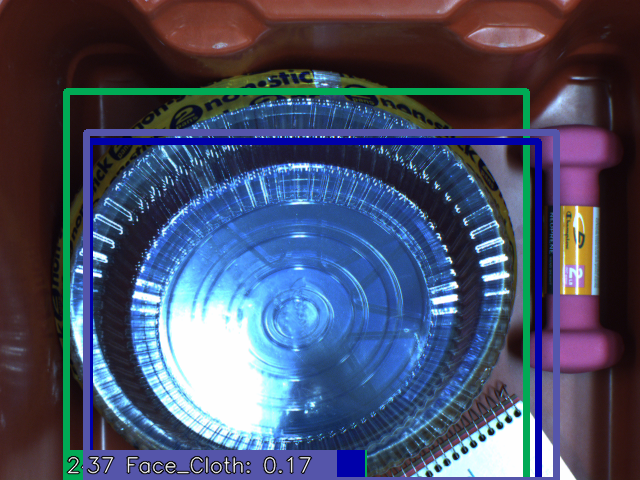

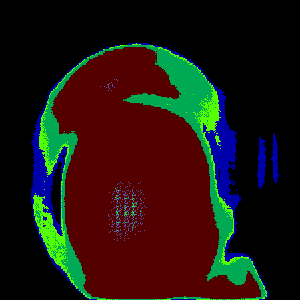

In [16]:
from IPython.display import Image,display_png
display_png(Image('./out/detection/2017-016-2.png'))
display_png(Image('./out/segmentation_results/2017-016-2.png'))

Bounding boxが表示されていますが，クラスが間違っていることがわかります．何度か試すと正しいクラスが出ることがありますが，これでは良い結果ではありません．さらに，セマンティックセグメンテーションの結果も理想とは言えません．30epochのみの学習のため，学習が足りずうまく検出・識別できていないことがわかります．

次に，物体検出結果を定量的に評価するためにスコアを計算します．この部分はSSDと同じなので，説明は割愛します．スコアは下記の3つを用います．
- 識別率: 検出された物体のうち，クラスが正しかった割合
- 未検出率: 全ての物体のうち，検出できなかった割合
- 平均IoU: 全てのバウンディングボックスのIoUの平均

In [17]:
%pwd
!ls ./val/rgb/
!ls ./out/detection_txt/

2017-001-1.png	2017-026-1.png	2017-051-1.png	2017-076-1.png	2017-101-1.png
2017-001-2.png	2017-026-2.png	2017-051-2.png	2017-076-2.png	2017-101-2.png
2017-006-1.png	2017-031-1.png	2017-056-1.png	2017-081-1.png	2017-106-1.png
2017-006-2.png	2017-031-2.png	2017-056-2.png	2017-081-2.png	2017-106-2.png
2017-011-1.png	2017-036-1.png	2017-061-1.png	2017-086-1.png	2017-111-1.png
2017-011-2.png	2017-036-2.png	2017-061-2.png	2017-086-2.png	2017-111-2.png
2017-016-1.png	2017-041-1.png	2017-066-1.png	2017-091-1.png	2017-116-1.png
2017-016-2.png	2017-041-2.png	2017-066-2.png	2017-091-2.png	2017-116-2.png
2017-021-1.png	2017-046-1.png	2017-071-1.png	2017-096-1.png	2017-121-1.png
2017-021-2.png	2017-046-2.png	2017-071-2.png	2017-096-2.png	2017-121-2.png
2017-001-2res.txt  2017-031-2res.txt  2017-061-2res.txt  2017-096-2res.txt
2017-006-1res.txt  2017-036-1res.txt  2017-066-1res.txt  2017-101-1res.txt
2017-006-2res.txt  2017-036-2res.txt  2017-066-2res.txt  2017-101-2res.txt
2017-011-1res.txt  2017-0

./out/detection_txt/2017-116-2res.txt
Result
Matching Success
Matching Failed
(3, 226, 85, 608, 254)0.784479122733024
(26, 24, 0, 210, 480)0.8532470288624788
(32, 200, 24, 602, 281)0.7573431819493335
No Match
(11, 238, 18, 472, 100)
(2, 344, 216, 640, 479)
(36, 126, 255, 409, 480)
File output
./out/detection_txt/2017-006-1res.txt
Result
Matching Success
Matching Failed
(3, 272, 315, 613, 480)0.890051433805397
(32, 375, 0, 630, 351)0.8320756392045454
(35, 268, 296, 609, 480)0.798640746009167
(36, 399, 0, 608, 310)0.8710322752734062
(37, 386, 8, 610, 313)0.9182448652974127
No Match
(21, 26, 360, 200, 480)
(22, 88, 135, 254, 480)
(11, 254, 80, 371, 322)
(8, 90, 0, 328, 152)
File output
./out/detection_txt/2017-101-1res.txt
Result
Matching Success
Matching Failed
(2, 76, 18, 273, 378)0.5152604449267498
(32, 208, 0, 640, 480)0.6725547718619312
(37, 279, 125, 608, 462)0.708342951808047
No Match
(23, 111, 138, 264, 274)
(28, 81, 0, 311, 31)
File output
./out/detection_txt/2017-111-2res.txt
Re

<Figure size 432x288 with 0 Axes>

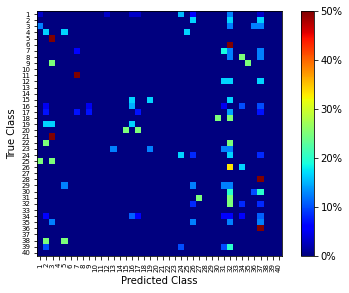

In [18]:
image_path = "./val/rgb/"
teach_path = "./val/boundingbox/"
result_path = "./out/detection_txt/"

# IoU matching results path
match_result_path = result_path + "/matchingResults/"

# evaluation output(totalresult, confusion_matrix) path
eval_result_path = result_path + "/eval/"

# wait time of cv2.waitKey (if 0 then no wait)
WAITTIME = 0

# if your detection results have a classlabel(e.g.: DVD, avery_binder...), set 1
LABEL_FLAG = 1

# if your detection results are normalized, set 1
NORMALIZED = 0

#IOU Threshold
# IOU_THRESH = 0.55
IOU_THRESH = 0.2

# if teach labels have category and color classification results, set 1
# normally need not change
CAT_PASS_FLAG = 0

# normally need not change
THRESH = 0.35
NCLASS = 40

COLOR_TABLE = common_params.arc_class_color
itemIDList = common_params.itemIDList

def convNormalizedCord(data, height, width):
    x = float(data[1]) * width
    y = float(data[2]) * height
    w = float(data[3]) * width
    h = float(data[4]) * height
    x1 = x - (w/2.)
    y1 = y - (h/2.)
    x2 = x + (w/2.)
    y2 = y + (h/2.)
    return(int(data[0]), int(x1), int(y1), int(x2), int(y2))

def convResCord(data, height, width, normalized):
    if normalized == 1:
        data = convNormalizedCord(data, height, width)
    if int(data[0]) == 0:
        classID = 41
    else:
        classID = int(data[0])
    return(classID, int(data[1]), int(data[2]), int(data[3]), int(data[4]) )

def getIOU(boxA, boxB):
    # if the length of between boxAcenter and boxBcenter is too far, return 0
    center_boxA = np.array([(boxA[0] + boxA[2]) / 2.0, (boxA[1] + boxA[3]) / 2.0])
    center_boxB = np.array([(boxB[0] + boxB[2]) / 2.0, (boxB[1] + boxB[3]) / 2.0])
    if np.linalg.norm(center_boxA - center_boxB) >= 500:
        return 0

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    inter_area = (xB - xA + 1) * (yB - yA + 1)
    boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = inter_area / float(boxA_area + boxB_area - inter_area)

    return iou

def readTxt(file_path, d_type, label_flag=0, cat_pass_flag=0):
    coordinate = []
    f = open(file_path, 'r')

    if f != None:
        for row in f:
            data = row.split()
            if(label_flag==1 and d_type == "result"):
                data = [data[0], data[2], data[3], data[4], data[5]]
            elif(d_type == "result"):
                data = [data[0], data[1], data[2], data[3], data[4]]
            elif(cat_pass_flag==1 and d_type == "teach"):
                data = [data[0], data[3], data[4], data[5], data[6]]
            elif(d_type == "teach" or d_type == "evaluate"):
                data = data
                # DO NOTHING
            else:
                print("[ERROR] Unexpected text data type:" + d_type)
                return 1
            coordinate.append(data)
        f.close()
        return coordinate
    else:
        print("[ERROR] Can't read:" + file_path)
        return 1

def drawBB(img, data):
    color = [ COLOR_TABLE[int(data[0])][2], COLOR_TABLE[int(data[0])][1], COLOR_TABLE[int(data[0])][0] ]
    height, width = img.shape[:2]
    x1 = data[1]
    y1 = data[2]
    x2 = data[3]
    y2 = data[4]
    cv.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
    cv.putText(img, itemIDList[int(data[0])], (x1, y1-2), cv.FONT_HERSHEY_TRIPLEX, 1, (255,255,255), 2)
    cv.putText(img, itemIDList[int(data[0])], (x1, y1), cv.FONT_HERSHEY_TRIPLEX, 1, (0,0,0), 1)
    return img

def matching(file_list):
    for file_path in file_list:
        print(file_path)
        file_name, ext = os.path.splitext(os.path.basename(file_path) )
        file_name = file_name.replace("res", "")

        result_data = readTxt(file_path, "result", label_flag=LABEL_FLAG)
        teach_data = readTxt(teach_path + file_name + ".txt", "teach", cat_pass_flag=CAT_PASS_FLAG)
        img = cv.imread(image_path + file_name + ".png")
        height, width = img.shape[:2]
        img_backup = img.copy()

        # Convert to Full(teach) coordinates
        for i in range(0, len(teach_data)):
            teach_data[i] = convNormalizedCord(teach_data[i], height, width)

        # Convert for result coordinates
        for i in range(0, len(result_data)):
            result_data[i] = convResCord(result_data[i], height, width, NORMALIZED)

        # init result lists
        hit = [False] * len(teach_data)
        success = [False] * len(result_data)
        max_IoU_list = [0] * len(result_data)
        true_category = [0] * len(result_data)

        # search box which have highest IoU value
        for j in range(0, len(result_data)):
            max_IoU = 0.0
            max_index = 0
            for i in range(0, len(teach_data)):
                iou = getIOU(teach_data[i][1:], result_data[j][1:])
                if(max_IoU < iou) and (iou <= 1.0):
                    max_IoU = iou
                    max_index = i
                if WAITTIME != 0:
                    img = img_backup.copy()
                    img = drawBB(img, teach_data[i])
                    img = drawBB(img, result_data[j])
                    cv.imshow("", img)
                    cv.waitKey(WAITTIME)

            # found
            max_IoU_list[j] = max_IoU
            img = img_backup.copy()
            if(max_IoU > THRESH):
                hit[max_index] = True
                success[j] = (teach_data[max_index][0] == result_data[j][0])
                true_category[j] = teach_data[max_index][0]
                if WAITTIME != 0:
                    img = drawBB(img, teach_data[max_index])
                    img = drawBB(img, result_data[j])
                    cv.putText(img, "Max IoU:" + str(max_IoU), (0, 25) , cv.FONT_HERSHEY_TRIPLEX, 1, (255,255,255), 2)
                    cv.putText(img, "Class Match:" + str(success[j]), (0, 50) , cv.FONT_HERSHEY_TRIPLEX, 1, (255,255,255), 2)
            else:
                if WAITTIME != 0:
                    img = drawBB(img, result_data[j])
                    cv.putText(img, "No Matching", (0, 25) , cv.FONT_HERSHEY_TRIPLEX, 1, (255,255,255), 2)
            if WAITTIME != 0:
                cv.imshow("", img)
                cv.waitKey(WAITTIME*5)

        print("Result")
        print("Matching Success")
        for i in range(0, len(result_data)):
            if(success[i] == True):
                print(str(result_data[i]))

        print("Matching Failed")
        for i in range(0, len(result_data)):
            if(success[i] == False):
                print(str(result_data[i]) + str(max_IoU_list[i]))

        print("No Match")
        for i in range(0, len(teach_data)):
            if(hit[i] == False):
                print(str(teach_data[i]))

        print("File output")
        f = open(result_path + "matchingResults/" + file_name + ".txt", 'w')
        for i in range(0, len(result_data)):
            write_data = str(result_data[i][0]) + " " + str(true_category[i]) + " " + str(max_IoU_list[i]) + '\n'
            f.writelines(write_data)
        # miss boxes
        for i in range(0, len(teach_data)):
            if(hit[i] == False):
                write_data = "0" + " " + str(teach_data[i][0]) + " 0.0" + '\n'
                f.writelines(write_data)
        f.close()

    if WAITTIME != 0:
        cv.destroyAllWindows()

def evaluate(file_list):
    conv_ID_table = [i for i in range(0, NCLASS+1)]

    total_boxes = 0             # number of all(detected + not detected) boxes
    total_true_boxes = 0        # number of true class boxes
    total_detected_boxes = 0    # number of detected boxes
    total_false_boxes = 0       # number of false class boxes
    total_undetected_boxes = 0  # number of not detected boxes
    total_IoU = 0.0

    confusion_mat = [[0 for i in range(NCLASS)] for j in range(NCLASS)]

    for filePath in file_list:
        boxes = 0
        true_boxes = 0
        detected_boxes = 0
        false_boxes = 0
        undetected_boxes = 0

        result_data = readTxt(filePath, "evaluate")

        for i in range(0, len(result_data)):
            boxes += 1
            if(result_data[i][0] != '0' and result_data[i][1] != '0'):
                #detected
                detected_boxes += 1
                total_IoU += float(result_data[i][2])
                confusion_mat[conv_ID_table[int(result_data[i][1])]-1][conv_ID_table[int(result_data[i][0])]-1] += 1
                if(float(result_data[i][2]) >= IOU_THRESH):
                    #IOU >= Threshold
                    if (result_data[i][0] == result_data[i][1]):
                        #true class
                        true_boxes += 1
                    else:
                        #false class
                        false_boxes += 1
                else:
                    #low IOU
                    false_boxes += 1
            else:
                #not detected
                undetected_boxes += 1

        if boxes != (detected_boxes + undetected_boxes):
            print("[Error] missmatch: boxes != detected_boxes + undetected_boxes")
            print(boxes, detected_boxes, undetected_boxes)
            sys.exit()
        if detected_boxes != (true_boxes + false_boxes):
            print("[Error] missmatch: detected_boxes != true_boxes + false_boxes")
            print(detected_boxes, true_boxes, false_boxes)
            sys.exit()

        total_boxes += boxes
        total_true_boxes += true_boxes
        total_detected_boxes += detected_boxes
        total_false_boxes += false_boxes
        total_undetected_boxes += undetected_boxes

    print("Total Result")
    print("Matching Rate: "+str(float(total_true_boxes) / float(total_detected_boxes)))
    print("Miss(No detection box) Rate: "+str(float(total_undetected_boxes) / float(total_boxes)))
    print("Mean IoU:"+ str(total_IoU / total_detected_boxes))

    #confusion_matrix normalization
    normalized_matrix = []
    for i in confusion_mat:
        a = 0
        temp_matrix = []
        a = sum(i,0)
        for j in i:
            if a == 0:
                temp_matrix.append(0.0)
            else:
                temp_matrix.append(float(j) / float(a))
        normalized_matrix.append(temp_matrix)

    #draw confusion_matrix
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    res = ax.imshow(array(normalized_matrix), cmap=cm.jet, interpolation='nearest')
    cb = fig.colorbar(res)
    cb.ax.set_yticklabels([str(i)+'%' for i in range(0, 101, 10)])
    confusion_mat = np.array(confusion_mat)
    width, height = confusion_mat.shape
    item_list = [str(i) for i in range(1, NCLASS+1)]
    plt.xticks(range(width), item_list[:width],rotation=90)
    plt.yticks(range(height), item_list[:height])
    plt.tick_params(labelsize=7)
    plt.subplots_adjust(left=0.05, bottom=0.10, right=0.95, top=0.95)
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")

    for i in range(0, NCLASS):
        print(str(i+1) + ": " + str(normalized_matrix[i][i]))

    #file output
    f = open(eval_result_path + "/totalresult.txt", 'w')
    f.writelines("Total Result" + '\n')
    f.writelines("Matching Rate: "+str(float(total_true_boxes) / float(total_detected_boxes)) + '\n')
    f.writelines("Miss(No detection box) Rate: "+str(float(total_undetected_boxes) / float(total_boxes)) + '\n')
    f.writelines("Mean IoU:"+ str(total_IoU / total_detected_boxes) + '\n')
    for i in range(0, NCLASS):
        f.writelines(str(i+1) + ": " + str(normalized_matrix[i][i]) + '\n')
    f.close()

    savefig(eval_result_path + "/confusion_matrix.pdf", format="pdf")
    savefig(eval_result_path + "/confusion_matrix.png", format="png")


def main():
    # mkdir for Matching results
    if not os.path.exists(result_path + "/matchingResults"): os.mkdir(result_path + "/matchingResults")
    if not os.path.exists(result_path + "/eval"): os.mkdir(result_path + "/eval")

    # IoU matching
    file_list = glob(result_path + "*.txt")
    if len(file_list) == 0:
        print("[Error] Detection results file list is empty. Check this dir:" + result_path)
        file_list.sort()
    else:
        matching(file_list)

    # evaluate and output
    file_list = glob(match_result_path + "/*.txt")
    if len(file_list) == 0:
        print("[Error] Evaluation file list is empty. Check this dir:" + match_result_path)
    else:
        file_list.sort()
        evaluate(file_list)

if __name__ == '__main__':
    main()


`Total Result`以降が学習済みモデルの評価結果を表しています．

```
Matching Rate: 0.09146341463414634
Miss(No detection box) Rate: 0.5260115606936416
Mean IoU:0.7627907384890055
```

30epochのみの学習のため，良い結果とは言えません．本来は150epochほど学習を進める必要があります．

また，Confusion matrixも画像として表示されています．対角線上に高い値があることが理想ですが，残念ながら全く実現できていません．

セマンティックセグメンテーションは，SegNetと同様にスコアを計算します．ネットワークから出力された300×300のクラスマップと，300×300にリサイズされた教師ラベルを1ピクセルずつ比較してaccuracyとmIoUを計算します．

In [19]:
class Evaluator(object):
    def __init__(self, num_class):
        
        self.num_class = num_class
        self.confusion_matrix = np.zeros((self.num_class,)*2)

    def Pixel_Accuracy(self):
        Acc = np.diag(self.confusion_matrix).sum() / self.confusion_matrix.sum()
        return Acc

    def Mean_Intersection_over_Union(self):
        MIoU = np.diag(self.confusion_matrix) / (
                    np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
                    np.diag(self.confusion_matrix))
        MIoU = np.nanmean(MIoU)
        return MIoU

    def _generate_matrix(self, gt_image, pre_image):
        mask = (gt_image >= 0) & (gt_image < self.num_class)
        label = self.num_class * gt_image[mask].astype('int') + pre_image[mask]
        count = np.bincount(label, minlength=self.num_class**2)
        confusion_matrix = count.reshape(self.num_class, self.num_class)
        return confusion_matrix

    def add_batch(self, gt_image, pre_image):
        assert gt_image.shape == pre_image.shape
        self.confusion_matrix += self._generate_matrix(gt_image, pre_image)

    def reset(self):
        self.confusion_matrix = np.zeros((self.num_class,) * 2)

evaluator = Evaluator(common_params.num_of_classes)
evaluator.reset()
OUT_DIR = "./out" 

gt_file = glob("./val/seglabel300/*.png")
pred_file = glob(OUT_DIR + "/segmentation_results_gray/*.png")
gt_file.sort()
pred_file.sort()

for num in range(len(gt_file)):
    gt_img = cv.imread(gt_file[num], cv.IMREAD_GRAYSCALE)
    pred_img = cv.imread(pred_file[num], cv.IMREAD_GRAYSCALE)

    if gt_img is None:
      print("Not found: " + str(gt_file[num]))
      exit()
    if pred_img is None:
      print("Not found: " + str(pred_file[num]))
      exit()
    evaluator.add_batch(gt_img, pred_img)

mIoU = evaluator.Mean_Intersection_over_Union()
Acc = evaluator.Pixel_Accuracy()
print("mean accuracy: {}，　mean IoU: {}".format(Acc, mIoU))

mean accuracy: 0.4537737777777778，　mean IoU: 0.033524485487735525


```
mean accuracy: 0.4601791111111111，　mean IoU: 0.03262478278088939
```
となりました．こちらも低い値です．

## 学習済みモデルによる評価
30エポックの学習では高い精度が得られないことがわかりました．もう少しデータ量を増やして，150エポックほど学習させると高い精度を得られます．しかし，それを行うには3日ほど必要なため，ここでは予め学習しておいた学習済みモデルによる評価を行います．

`MODEL_PATH`に学習済みモデルを指定して実行します． また，  `ssd_pretrained.load_state_dict(torch.load(MODEL_PATH))` で保存済みのモデルをネットワークに反映させます．その他は，先程の評価コードと同じです．

In [20]:
IN_DIR = "./val/rgb"                 # 評価データのパス
OUT_DIR = "./out_pretrained"        # 結果保存先
MODEL_PATH = "./MTDSSD_pretrained.pth"  # モデルのパス

# クラスラベル
print(len(labels))
def test_out2():
    # ディレクトリの作成
    if SAVE_DATA:
        make_dir_list = [
            OUT_DIR,
            OUT_DIR + '/detection',                     # 検出結果のb-box画像
            OUT_DIR + '/segmentation_results',          # セグメンテーション結果
            OUT_DIR + '/segmentation_results_large',    # セグメンテーション結果(入力サイズに拡大)
            OUT_DIR + '/segmentation_results_gray',     # セグメンテーション結果(グレースケール)
            OUT_DIR + '/detection_txt'                  # 検出結果のb-boxテキスト
        ]
        for dirname in make_dir_list:
            if not(os.path.exists(dirname)): os.mkdir(dirname)
    # 学習モデル読み込み
    ssd_pretrained = MTDSSDNet()
    ssd_pretrained.load_state_dict(torch.load(MODEL_PATH))
    ssd_pretrained.to(device)

    # default boxのサイズリスト計算
    step = int(math.floor((common_params.max_ratio - common_params.min_ratio) / (len(common_params.mbox_source_layers) - 2)))
    min_sizes = []
    max_sizes = []
    for ratio in range(common_params.min_ratio, common_params.max_ratio + 1, step):
            min_sizes.append(common_params.insize * ratio / 100.)
            max_sizes.append(common_params.insize * (ratio + step) / 100.)
    min_sizes = [common_params.insize * 10 / 100.] + min_sizes
    max_sizes = [common_params.insize * 20 / 100.] + max_sizes

    # 入力画像の読み込み
    color_img = glob(os.path.join(IN_DIR, '*' + '.png'))
    color_img.sort()

    # 読み込んだリストを順次検出
    ssd_pretrained.eval()
    for lf in range(len(color_img)):
        print("{} / {}".format(lf+1, len(color_img)))
        img = cv.imread(color_img[lf])
        filename, ext = os.path.splitext(os.path.basename(color_img[lf]))
        detection(img, ssd_pretrained, filename, min_sizes, max_sizes)

if __name__ == '__main__':
    test_out2()

41
1 / 50
----- Detection Done -----
2 / 50
----- Detection Done -----
3 / 50
----- Detection Done -----
4 / 50
----- Detection Done -----
5 / 50
----- Detection Done -----
6 / 50
----- Detection Done -----
7 / 50
----- Detection Done -----
8 / 50
----- Detection Done -----
9 / 50
----- Detection Done -----
10 / 50
----- Detection Done -----
11 / 50
----- Detection Done -----
12 / 50
----- Detection Done -----
13 / 50
----- Detection Done -----
14 / 50
----- Detection Done -----
15 / 50
----- Detection Done -----
16 / 50
----- Detection Done -----
17 / 50
----- Detection Done -----
18 / 50
----- Detection Done -----
19 / 50
----- Detection Done -----
20 / 50
----- Detection Done -----
21 / 50
----- Detection Done -----
22 / 50
----- Detection Done -----
23 / 50
----- Detection Done -----
24 / 50
----- Detection Done -----
25 / 50
----- Detection Done -----
26 / 50
----- Detection Done -----
27 / 50
----- Detection Done -----
28 / 50
----- Detection Done -----
29 / 50
----- Detection Do

先程と同様に物体検出の評価を行います．

./out_pretrained/detection_txt/2017-116-2res.txt
Result
Matching Success
(2, 356, 232, 639, 480)
(11, 236, 15, 480, 101)
(24, 3, 0, 227, 475)
(35, 212, 68, 595, 261)
(36, 119, 265, 429, 480)
Matching Failed
No Match
File output
./out_pretrained/detection_txt/2017-006-1res.txt
Result
Matching Success
(3, 390, 1, 620, 327)
(8, 92, 0, 335, 152)
(9, 281, 325, 601, 480)
(11, 244, 81, 369, 320)
(21, 28, 350, 206, 479)
(22, 86, 144, 276, 480)
Matching Failed
(36, 285, 324, 602, 479)0.9571199624750811
No Match
File output
./out_pretrained/detection_txt/2017-101-1res.txt
Result
Matching Success
(12, 280, 16, 614, 446)
(22, 65, 148, 212, 457)
(23, 114, 136, 256, 273)
Matching Failed
No Match
(28, 81, 0, 311, 31)
File output
./out_pretrained/detection_txt/2017-111-2res.txt
Result
Matching Success
(1, 0, 190, 206, 480)
(6, 432, 435, 551, 480)
(12, 555, 51, 640, 477)
(14, 447, 73, 565, 253)
(17, 197, 351, 429, 480)
(37, 66, 42, 425, 382)
(40, 449, 279, 568, 428)
Matching Failed
(14, 437, 439, 551, 

<Figure size 432x288 with 0 Axes>

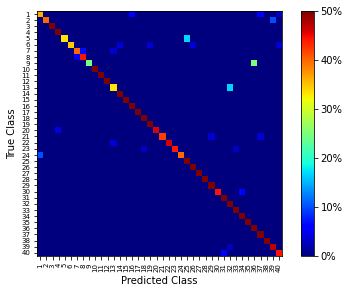

In [21]:
result_path = "./out_pretrained/detection_txt/"

# IoU matching results path
match_result_path = result_path + "/matchingResults/"

# evaluation output(totalresult, confusion_matrix) path
eval_result_path = result_path + "/eval/"

def main():
    # mkdir for Matching results
    if not os.path.exists(result_path + "/matchingResults"): os.mkdir(result_path + "/matchingResults")
    if not os.path.exists(result_path + "/eval"): os.mkdir(result_path + "/eval")

    # IoU matching
    file_list = glob(result_path + "*.txt")
    if len(file_list) == 0:
        print("[Error] Detection results file list is empty. Check this dir:" + result_path)
        file_list.sort()
    else:
        matching(file_list)

    # evaluate and output
    file_list = glob(match_result_path + "/*.txt")
    if len(file_list) == 0:
        print("[Error] Evaluation file list is empty. Check this dir:" + match_result_path)
    else:
        file_list.sort()
        evaluate(file_list)

if __name__ == '__main__':
    main()

```
Matching Rate: 0.9131832797427653
Miss(No detection box) Rate: 0.028125
Mean IoU:0.9116157335649024
```

になりました．今回よりも大きなデータセットで，かつ多くの時間をかけて学習しているため，かなり精度が向上しています．

Confusion matrixも，対角線上に高い値が出ていることがわかります．

セマンティックセグメンテーションの評価も行いましょう．

In [22]:
evaluator = Evaluator(common_params.num_of_classes)
evaluator.reset()
OUT_DIR = "./out_pretrained"

gt_file = glob("./val/seglabel300/*.png")
pred_file = glob(OUT_DIR + "/segmentation_results_gray/*.png")
gt_file.sort()
pred_file.sort()


for num in range(len(gt_file)):
    gt_img = cv.imread(gt_file[num], cv.IMREAD_GRAYSCALE)
    pred_img = cv.imread(pred_file[num], cv.IMREAD_GRAYSCALE)

    if gt_img is None:
      print("Not found: " + str(gt_file[num]))
      exit()
    if pred_img is None:
      print("Not found: " + str(pred_file[num]))
      exit()
    evaluator.add_batch(gt_img, pred_img)

mIoU = evaluator.Mean_Intersection_over_Union()
Acc = evaluator.Pixel_Accuracy()
print("mean accuracy: {}，　mean IoU: {}".format(Acc, mIoU))

mean accuracy: 0.9516948888888889，　mean IoU: 0.8729181565476937


```
mean accuracy: 0.9516948888888889，　mean IoU: 0.8729181565476937
```
となりました．セマンティックセグメンテーションも大きく精度が向上しています．

このモデルは，学習画像枚数を1,210枚とし，data augmentationも30倍行っています．また，学習エポック数は150とかなり長い時間をかけて作成したものです．深層学習を行うときに「データ数」と「学習時間」が重要であることもわかります．

# 課題
1. エポック数を変えて実験し，精度の変化を確認しましょう．
2. 誤差関数の重みを変更して，精度の変化を確認しましょう．

# 参考文献
 - [1] R. Araki, T. Onishi, T. Hirakawa, T. Yamashita and H. Fujiyoshi, “MT-DSSD: Deconvolutional Single Shot Detector Using Multi Task Learning for Object Detection”. In 2020 IEEE International Conference on Robotics and Automation, pp. 10487-10493, 2020.
 - [2] W. Liu, D. Anguelov, D. Erhan, C. Szegedy, S. Reed, C.-Y. Fu, and A. C. Berg, “SSD: Single Shot Multibox Detector,” in European Conference on Computer Vision. Springer, 2016, pp. 21-37.
 - [3] C.-Y. Fu, W. Liu, A. Ranga, A. Tyagi, and A. C. Berg, “DSSD: De- convolutional Single Shot Detector,” arXiv preprint arXiv:1701.06659, 2017.